# Compare predictive performance within endpoint categories

Use one representation (CellProfiler) and profile consensus strategy ("all") to do these comparisons. Keep the cytotox, but convert to a histogram with two vertical lines. Do not use the current comparisons; they are too different in terms of compound number and class balance. Instead, look at the biggest groups of assays and see if the relative performance across targets makes sense.  

In [ ]:
import polars as pl 
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

## Input annotations

In [2]:
endpoint_types = ["toxcast_cellbased", "toxcast_cellfree", "toxcast_cytotox", "axiom"]

pred_df = []
for et in endpoint_types:
    preds = pl.read_parquet(f"../compiled_results/compiled_{et}_metrics.parquet")
    preds = preds.with_columns(
        (pl.col("Metadata_Count_0") + pl.col("Metadata_Count_1")).alias("Total_Compounds"),
        pl.lit(et).alias("Endpoint_type")
    )
    pred_df.append(preds)

pred_df = pl.concat(pred_df, how="vertical")
pred_df = pred_df.with_columns(
    pl.when(pl.col("Endpoint_type") == "axiom").then(pl.lit("axiom_cytotox")).otherwise(pl.col("Endpoint_type")).alias("Endpoint_type")
)

pred_df = (pred_df
            .filter(pl.col("Model_type") == "Actual")
            .filter(pl.col("Feat_type") == "cellprofiler")
            .filter(pl.col("Metadata_AggType") == "all"))

## Cytotox: liver vs. non-liver

In [3]:
# what are the top performing toxcast_cytotox cell lines?
cyto_df = (pred_df.filter(pl.col("Endpoint_type") == "toxcast_cytotox")
                  .filter(pl.col("Model_type") == "Actual")
                  .filter(pl.col("Total_Compounds") > 100)
                  .with_columns(
                    pl.when(pl.col("Metadata_Label").is_in(["tissue__liver", "cell_type__HepG2"])).then(pl.lit("Liver")).otherwise(pl.lit("Non-liver")).alias("Tissue_source")
                  ))
cyto_pandas = cyto_df.to_pandas()

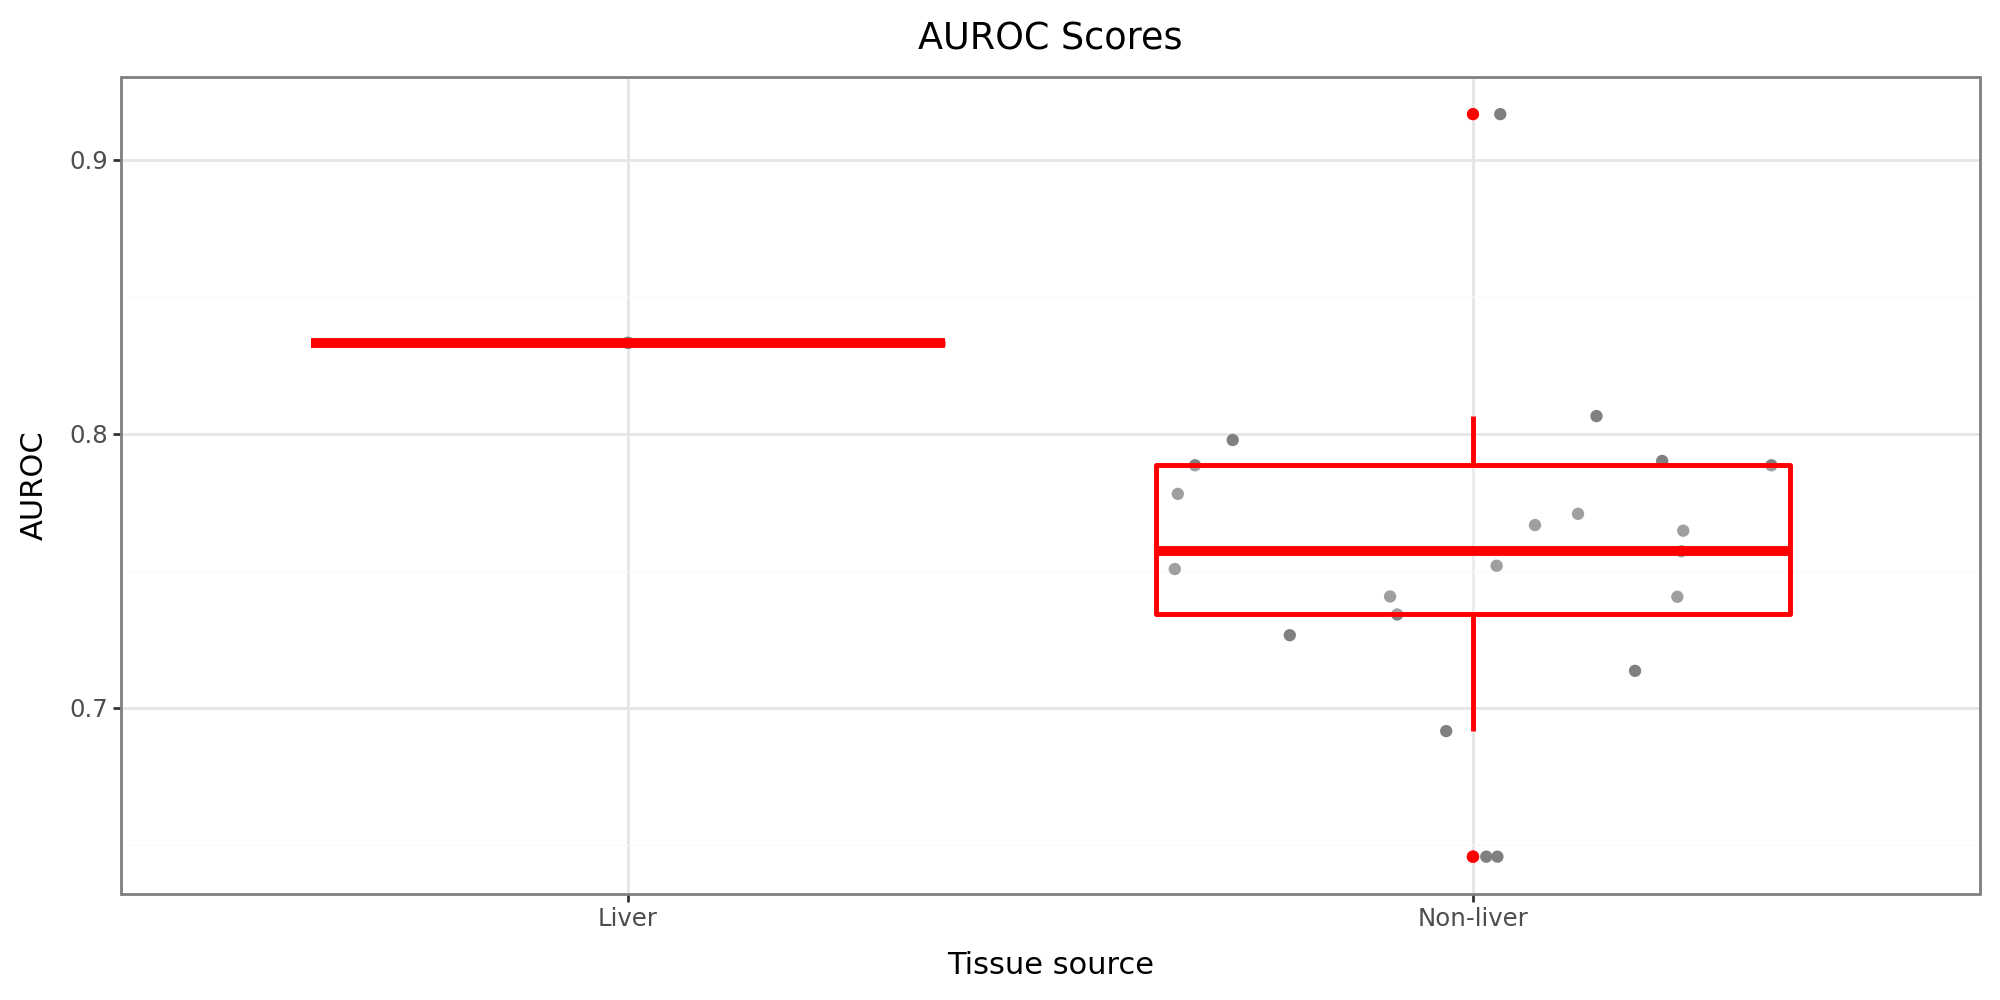

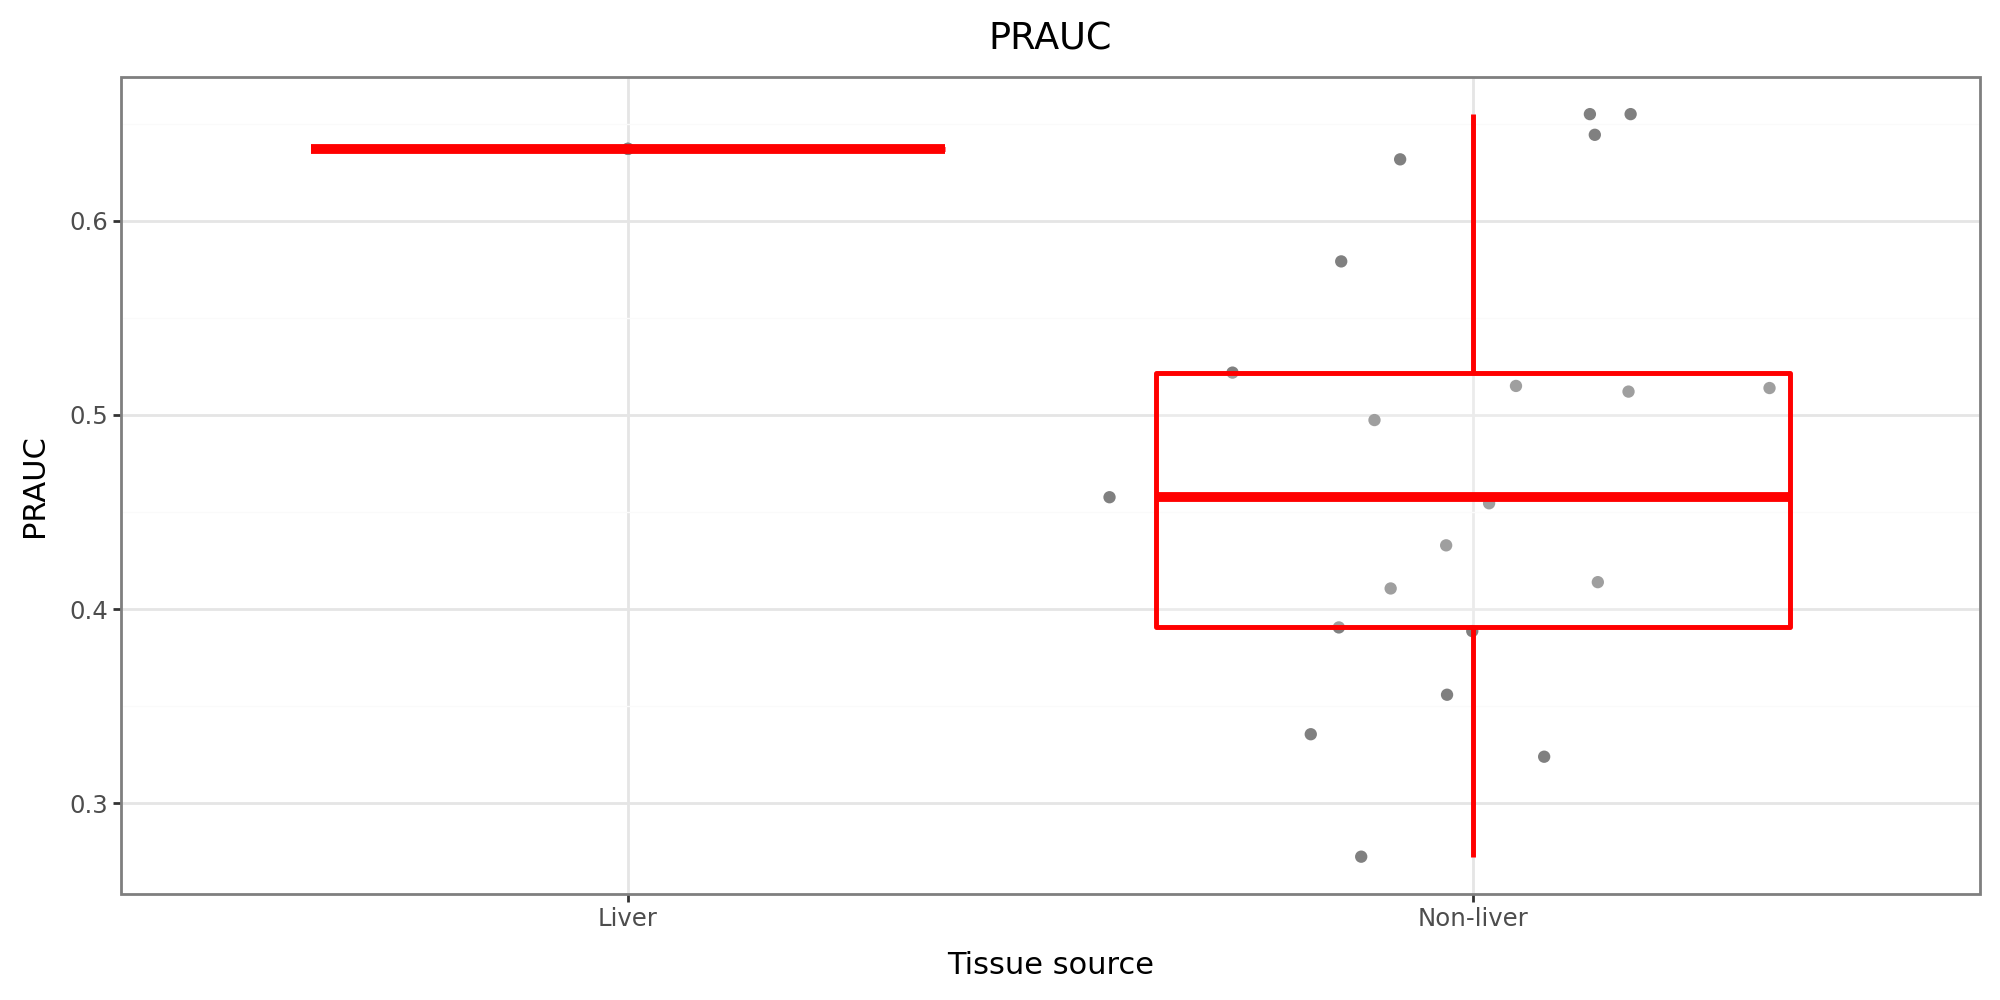

In [4]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(cyto_df, aes(x='Tissue_source', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores', x='Tissue source', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cyto_df, aes(x='Tissue_source', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='PRAUC', x='Tissue source', y='PRAUC') 
    + theme_bw()
)
plot.show()

## Find cell-based assays measured for many targets with same compound number

In [28]:
cell_info = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cellbased_info.parquet").select([
    "assay_component_endpoint_name", "assay_component_desc", "tissue", "cell_short_name", 
    "intended_target_type", "intended_target_type_sub", "assay_function_type",
    "intended_target_family", "intended_target_family_sub"
]).unique().rename({"assay_component_endpoint_name": "Metadata_Label"})

cell_info = cell_info.join(pred_df.select(["Metadata_Label", "Total_Compounds", "Metadata_Count_1", "AUROC"]).unique(),
                           on="Metadata_Label", how="inner").filter(
                            pl.col("Total_Compounds") >= 100
                           ).sort(
                            [pl.col("cell_short_name"), pl.col("Total_Compounds")], descending=True
                            )

In [ ]:
cp_pred = pl.read_parquet("../../1_snakemake/outputs/cellprofiler/mad_featselect/classifier_results/toxcast_cellbased_binary_predictions.parquet")

cp_pred = cp_pred.filter(
    pl.col("Model_type") == "Actual"
    ).filter(pl.col("Metadata_AggType") == "all")

In [68]:
oasis = pl.read_csv("../../1_snakemake/inputs/annotations/seal_input/v5_oasis_03Sept2024_simple.csv")

In [33]:
heparg_mrna = cell_info.filter(pl.col("cell_short_name") == "HepaRG").filter(pl.col("Total_Compounds") == 167) 

hepg2_prot = cell_info.filter(pl.col("cell_short_name") == "HepG2").filter(pl.col("Total_Compounds") == 298)

hepg2_morph = cell_info.filter(pl.col("cell_short_name") == "HepG2").filter(pl.col("Total_Compounds") == 164)

### HepaRG (mRNA)

In [46]:
heparg_mrna_df = cp_pred.filter(pl.col("Metadata_Label").is_in(heparg_mrna.select("Metadata_Label").to_series().to_list()))

heparg_mrna_df = heparg_mrna_df.pivot(
    index="Metadata_OASIS_ID",
    on="Metadata_Label",
    values="y_prob"
)

heparg_mrna_df = heparg_mrna_df.to_pandas()
heparg_mrna_df.set_index("Metadata_OASIS_ID", inplace=True)
data_matrix = heparg_mrna_df.values

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


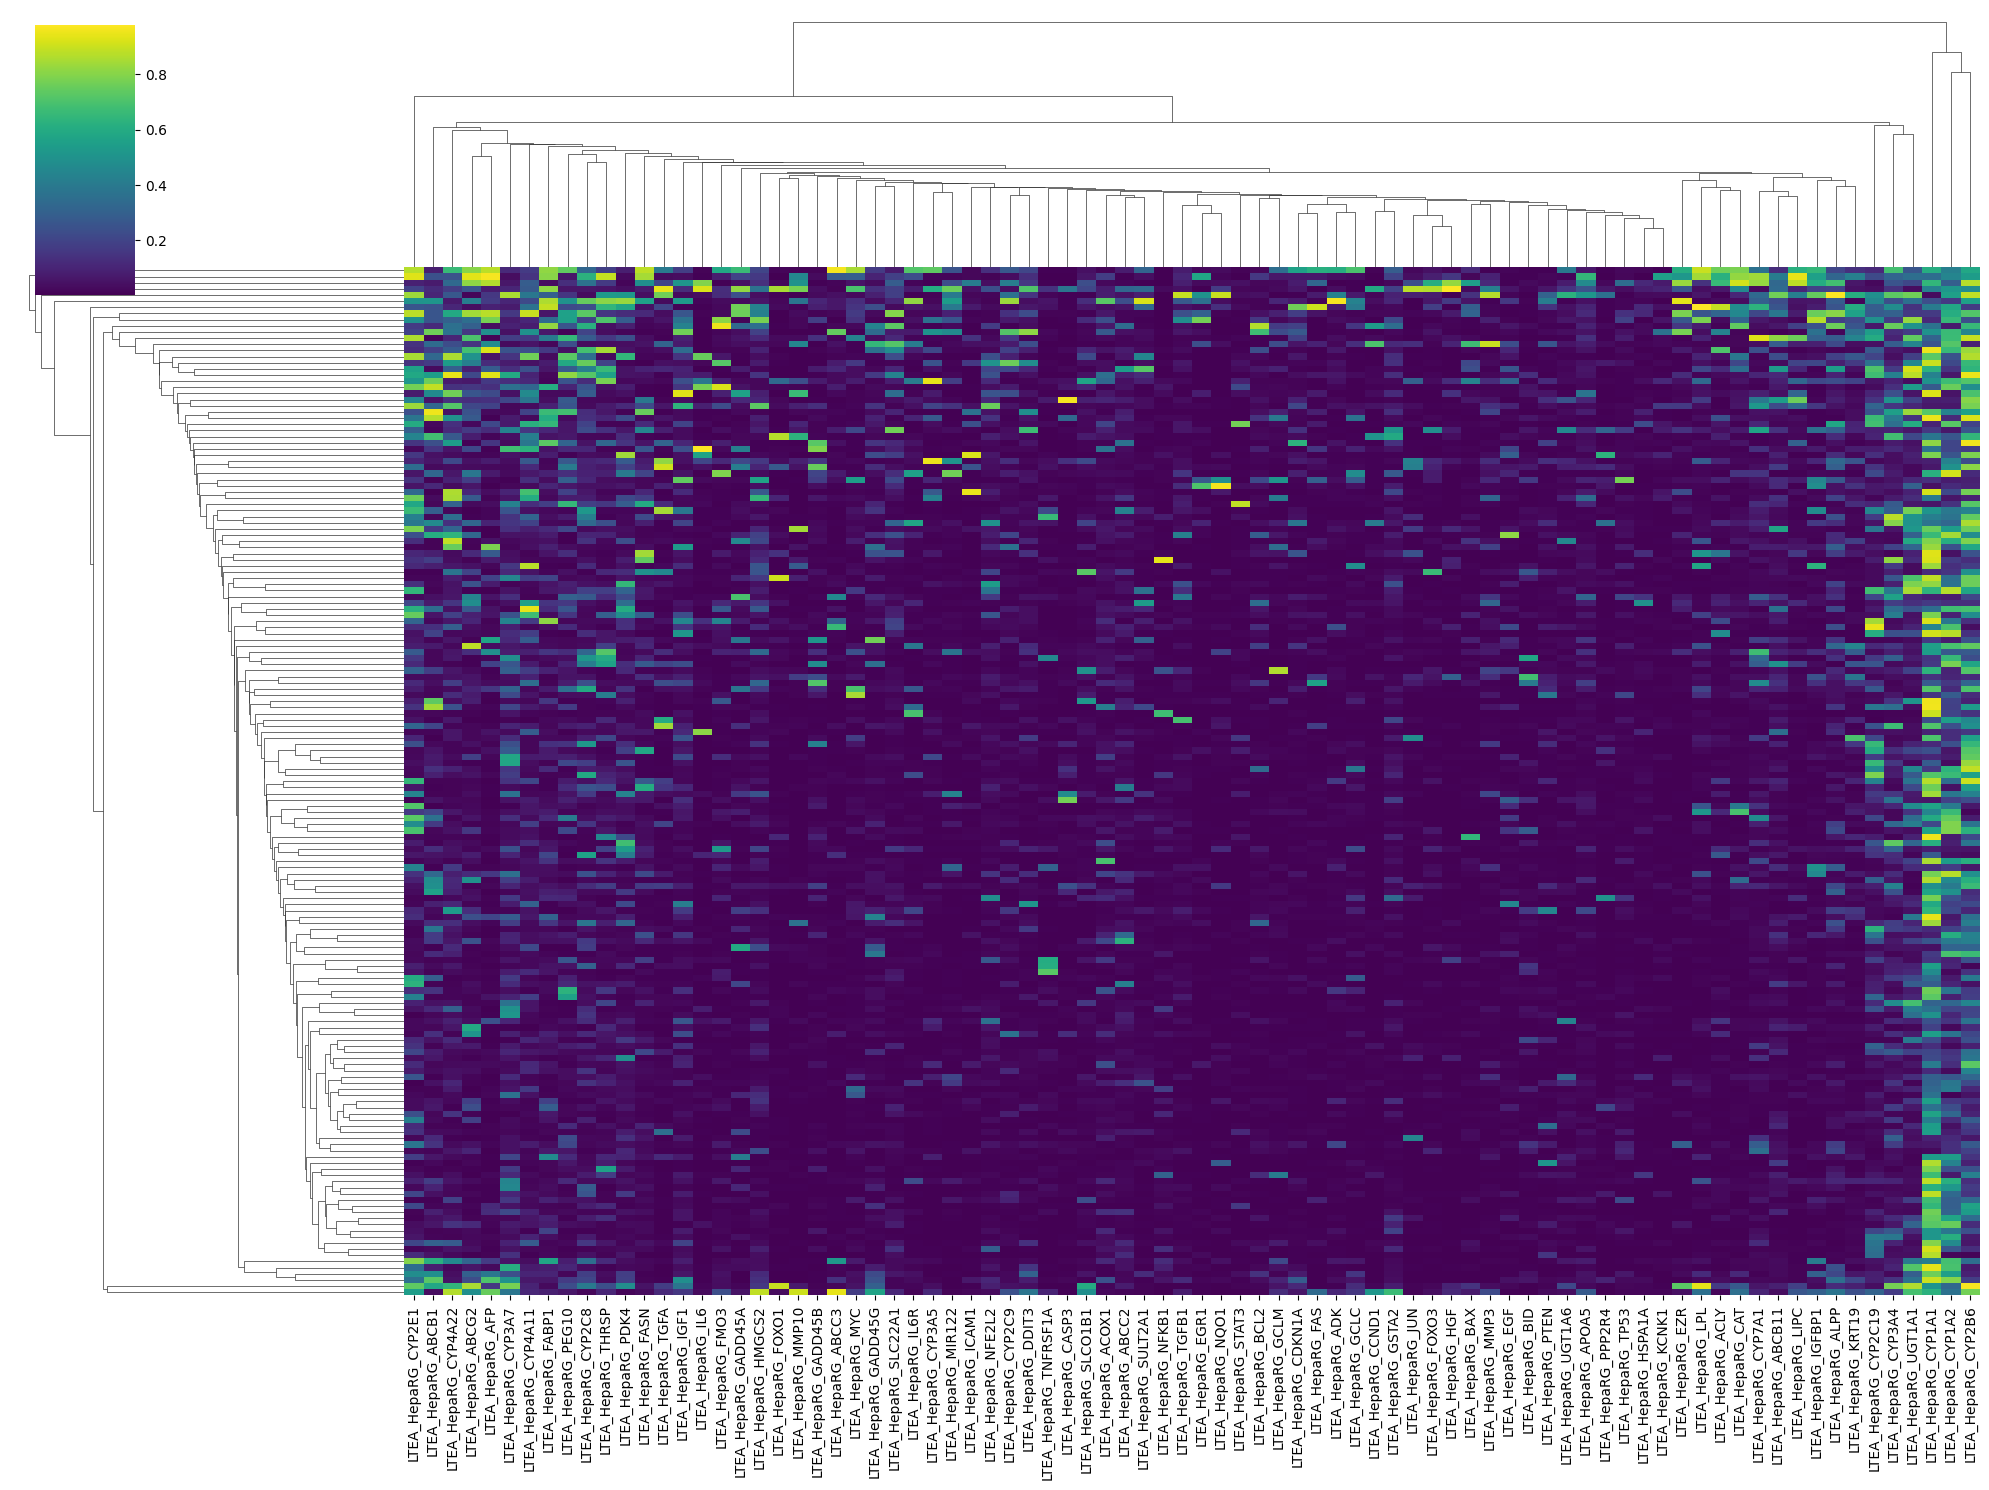

In [ ]:
sns.clustermap(
    data_matrix,
    cmap="viridis",
    row_cluster=True,
    col_cluster=True,
    xticklabels=heparg_mrna_df.columns,
    yticklabels=False,
    figsize=(20, 15)
)
plt.show()

### HepG2 (protein)

In [54]:
hepg2_prot_df = cp_pred.filter(pl.col("Metadata_Label").is_in(hepg2_prot.select("Metadata_Label").to_series().to_list()))

hepg2_prot_df = hepg2_prot_df.pivot(
    index="Metadata_OASIS_ID",
    on="Metadata_Label",
    values="y_prob"
)

hepg2_prot_df = hepg2_prot_df.to_pandas()
hepg2_prot_df.set_index("Metadata_OASIS_ID", inplace=True)
data_matrix = hepg2_prot_df.values

In [ ]:
# Get last 10 rows
clustergrid = sns.clustermap(
    data_matrix,
    cmap="viridis",
    row_cluster=True,
    col_cluster=True,
    xticklabels=hepg2_prot_df.columns,
    yticklabels=False,
    figsize=(20, 15)
)
row_linkage = clustergrid.dendrogram_row.linkage
row_order = clustergrid.dendrogram_row.reordered_ind
hepg2_prot_df = hepg2_prot_df.iloc[row_order]

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


In [82]:
cmpd_cluster = list(hepg2_prot_df.index[-10:])
universe = list(hepg2_prot_df.index)
oasis_cluster = oasis.filter(pl.col("OASIS_ID").is_in(cmpd_cluster)).rename({"OASIS_ID": "Unique_ID"})
oasis_cluster


Unique_ID,DTXSID,PREFERRED_NAME,DTXCID,CASRN,INCHIKEY,IUPAC_NAME,SMILES,INCHI_STRING,DILILIST_ID,DILIRANK2_ID,DRUGMATRIX_ID,FRAUNHOFER_ID,ICE_ID,TGGATES_ID,TOXREFDB_ID,Invivo_ranking,Purchased_Broad_Enamine,Purchased_Broad_Molport,Purchased_Axiom_Medchemxpress
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str
"""OASIS569""","""DTXSID7037185""","""Amiodarone hydrochloride""","""DTXCID5017185""","""19774-82-4""","""ITPDYQOUSLNIHG-UHFFFAOYSA-N""","""(2-Butyl-1-benzofuran-3-yl){4-…","""Cl.CCCCC1=C(C(=O)C2=CC(I)=C(OC…","""InChI=1S/C25H29I2NO3.ClH/c1-4-…",null,null,null,"""fraunhofer_266""",null,null,null,3,"""No""","""Yes""","""Yes"""
"""OASIS1282""","""DTXSID7021237""","""Reserpine""","""DTXCID201237""","""50-55-5""","""QEVHRUUCFGRFIF-MDEJGZGSSA-N""","""Methyl 11,17alpha-dimethoxy-18…","""[H][C@]12C[C@@H](OC(=O)C3=CC(O…","""InChI=1S/C33H40N2O9/c1-38-19-7…","""dilist_829""",null,null,null,null,null,null,4,"""Yes""","""No""","""Yes"""
"""OASIS1288""","""DTXSID7022598""","""Amoxapine""","""DTXCID102598""","""14028-44-5""","""QWGDMFLQWFTERH-UHFFFAOYSA-N""","""2-Chloro-11-(piperazin-1-yl)di…","""ClC1=CC=C2OC3=C(C=CC=C3)N=C(N3…","""InChI=1S/C17H16ClN3O/c18-12-5-…","""dilist_601""",null,null,null,null,null,null,4,"""Yes""","""No""","""Yes"""
"""OASIS1402""","""DTXSID8022828""","""Cladribine""","""DTXCID602828""","""4291-63-8""","""PTOAARAWEBMLNO-KVQBGUIXSA-N""","""2-Chloro-2'-deoxyadenosine""","""NC1=NC(Cl)=NC2=C1N=CN2[C@H]1C[…","""InChI=1S/C10H12ClN5O3/c11-10-1…","""dilist_927""",null,null,null,null,null,null,4,"""No""","""Yes""","""Yes"""
"""OASIS573""","""DTXSID9032537""","""Didecyldimethylammonium chlori…","""DTXCID7012537""","""7173-51-5""","""RUPBZQFQVRMKDG-UHFFFAOYSA-M""","""N-Decyl-N,N-dimethyldecan-1-am…","""[Cl-].CCCCCCCCCC[N+](C)(C)CCCC…","""InChI=1S/C22H48N.ClH/c1-5-7-9-…",null,null,null,"""fraunhofer_271""",null,null,null,3,"""No""","""Yes""","""Yes"""
"""OASIS1225""","""DTXSID6023652""","""6-Thioguanine""","""DTXCID803652""","""154-42-7""","""WYWHKKSPHMUBEB-UHFFFAOYSA-N""","""2-Amino-1,7-dihydro-6H-purine-…","""NC1=NC2=C(NC=N2)C(=S)N1""","""InChI=1S/C5H5N5S/c6-5-9-3-2(4(…","""dilist_961""",null,null,null,null,null,null,4,"""Yes""","""No""","""Yes"""
"""OASIS1313""","""DTXSID7023300""","""Methylprednisolone""","""DTXCID903300""","""83-43-2""","""VHRSUDSXCMQTMA-PJHHCJLFSA-N""","""11beta,17,21-Trihydroxy-6alpha…","""[H][C@@]12CC[C@](O)(C(=O)CO)[C…","""InChI=1S/C22H30O5/c1-12-8-14-1…","""dilist_366""",null,null,null,null,null,null,4,"""No""","""Yes""","""Yes"""
"""OASIS1501""","""DTXSID9020110""","""Astemizole""","""DTXCID30110""","""68844-77-9""","""GXDALQBWZGODGZ-UHFFFAOYSA-N""","""1-[(4-Fluorophenyl)methyl]-N-{…","""COC1=CC=C(CCN2CCC(CC2)NC2=NC3=…","""InChI=1S/C28H31FN4O/c1-34-25-1…","""dilist_802""",null,null,null,null,null,null,4,"""Yes""","""No""","""Yes"""
"""OASIS1098""","""DTXSID5022934""","""Digoxin""","""DTXCID502934""","""20830-75-5""","""LTMHDMANZUZIPE-PUGKRICDSA-N""","""3beta-{[2,6-Dideoxy-beta-D-rib…","""C[C@H]1O[C@H](C[C@H](O)[C@@H]1…","""InChI=1S/C41H64O14/c1-19-36(47…","""dilist_383""",null,null,null,null,null,null,4,"""Yes""","""No""","""Yes"""


In [86]:
# create enrichment sets
targets = pl.read_parquet("../../1_snakemake/inputs/annotations/cg_motive.parquet")
targets = targets.filter(pl.col("interaction_type") == "unknown_direction")
targets = targets.select(["target", "OASIS_ID"]).unique()

target_set_size = targets.select(pl.col("target").value_counts()).unnest("target").filter(pl.col("count") >= 3)
keep_sets = target_set_size.select("target").to_series().to_list()
targets = targets.filter(pl.col("target").is_in(keep_sets)).rename({
    "target": "target_set",
    "OASIS_ID": "Unique_ID"})

import polars as pl
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

def overrepresentation_analysis(target_set_library: pl.DataFrame, target_hits: list, universe: list):
    target_hits_set = set(target_hits)
    universe_set = set(universe)
    sets = target_set_library.select(pl.col("target_set")).unique().to_series()
    results = []

    # For each target set, calculate the overlap and perform the hypergeometric test
    for target_set in tqdm(sets):
        targets_in_set = set(target_set_library.filter(pl.col("target_set") == target_set)["Unique_ID"].to_list())
        
        overlap = target_hits_set.intersection(targets_in_set)
        overlap_size = len(overlap)

        M = len(universe_set)  # Total number of genes in the universe
        n = len(targets_in_set)  # Number of genes in the gene set
        N = len(target_hits_set)  # Number of gene hits
        x = overlap_size  # Number of overlapping genes (successes)

        p_value = hypergeom.sf(x - 1, M, n, N)

        results.append({
            "target_set": target_set,
            "overlap_size": overlap_size,
            "target_set_size": n,
            "hit_list_size": N,
            "universe_size": M,
            "p_value": p_value,
            "overlap_hits": ",".join(overlap),
        })

    return pl.DataFrame(results)

# FDR adjust the p-values
def fdr_polars(df: pl.DataFrame):
    p_values = df.select("p_value").to_series().to_numpy()
    _, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False)
    df = df.with_columns(pl.Series("fdr", p_adjusted))
    return df

In [87]:
clust1_results = overrepresentation_analysis(targets, cmpd_cluster, universe)
clust1_results = fdr_polars(clust1_results).sort("fdr")
clust1_results = clust1_results.select(["target_set", "p_value", "fdr", "overlap_size", "target_set_size", "overlap_hits"]).sort("fdr")

100%|██████████| 8864/8864 [00:02<00:00, 3311.74it/s]


/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


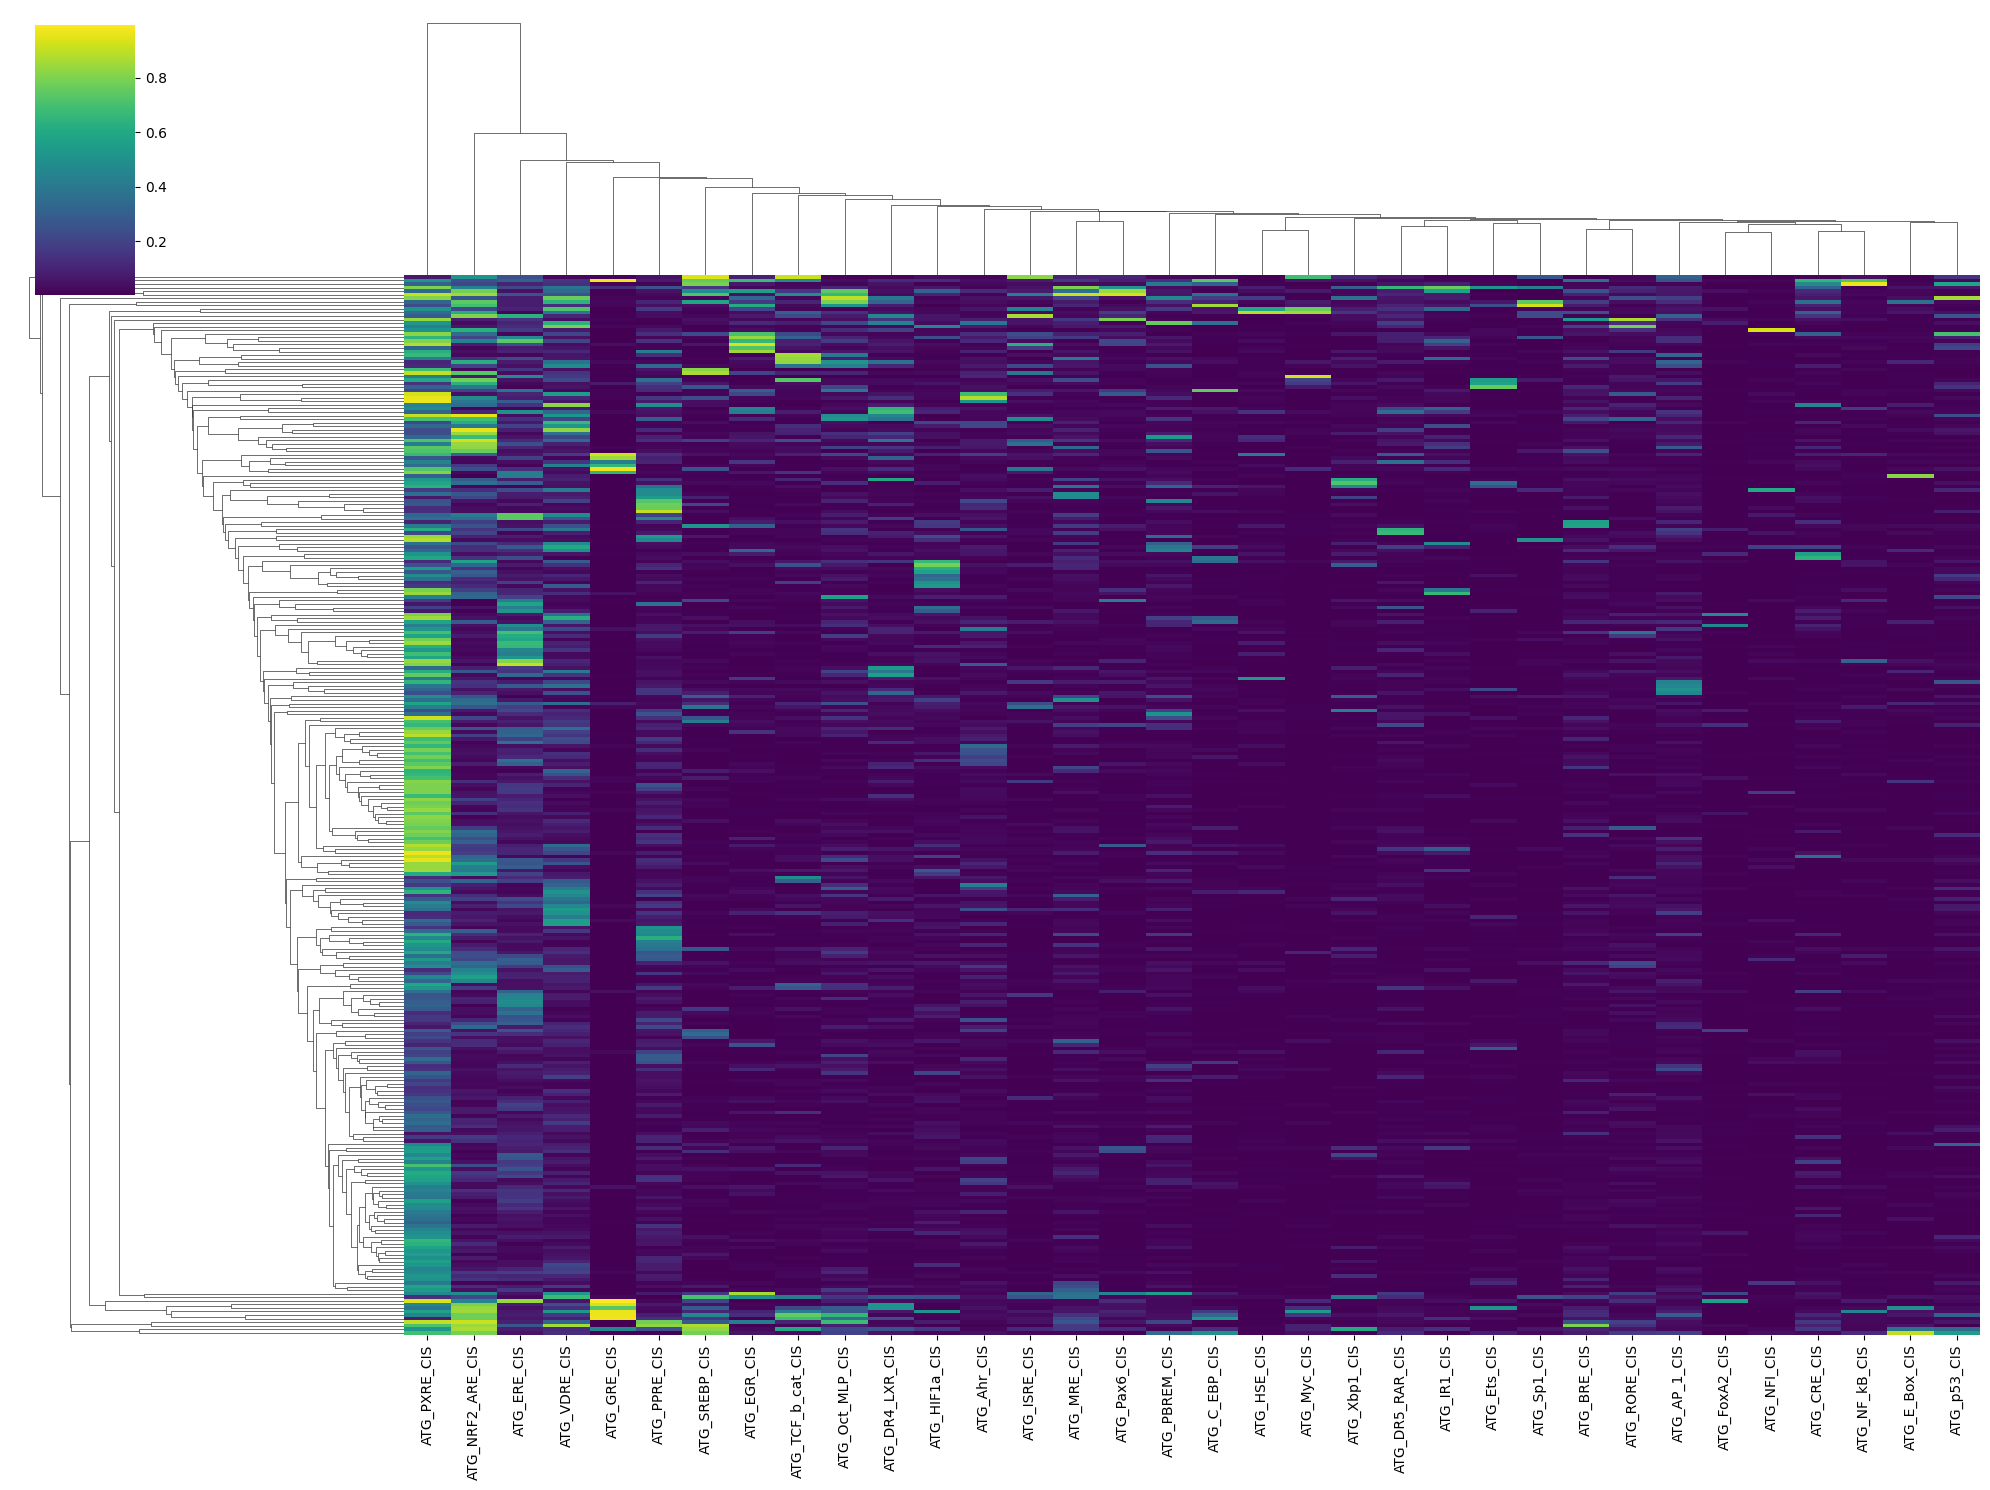

In [51]:
sns.clustermap(
    data_matrix,
    cmap="viridis",
    row_cluster=True,
    col_cluster=True,
    xticklabels=hepg2_prot_df.columns,
    yticklabels=False,
    figsize=(20, 15)
)
plt.show()

### HepG2 (morph)

In [52]:
hepg2_morph_df = cp_pred.filter(pl.col("Metadata_Label").is_in(hepg2_morph.select("Metadata_Label").to_series().to_list()))

hepg2_morph_df = hepg2_morph_df.pivot(
    index="Metadata_OASIS_ID",
    on="Metadata_Label",
    values="y_prob"
)

hepg2_morph_df = hepg2_morph_df.to_pandas()
hepg2_morph_df.set_index("Metadata_OASIS_ID", inplace=True)
data_matrix = hepg2_morph_df.values

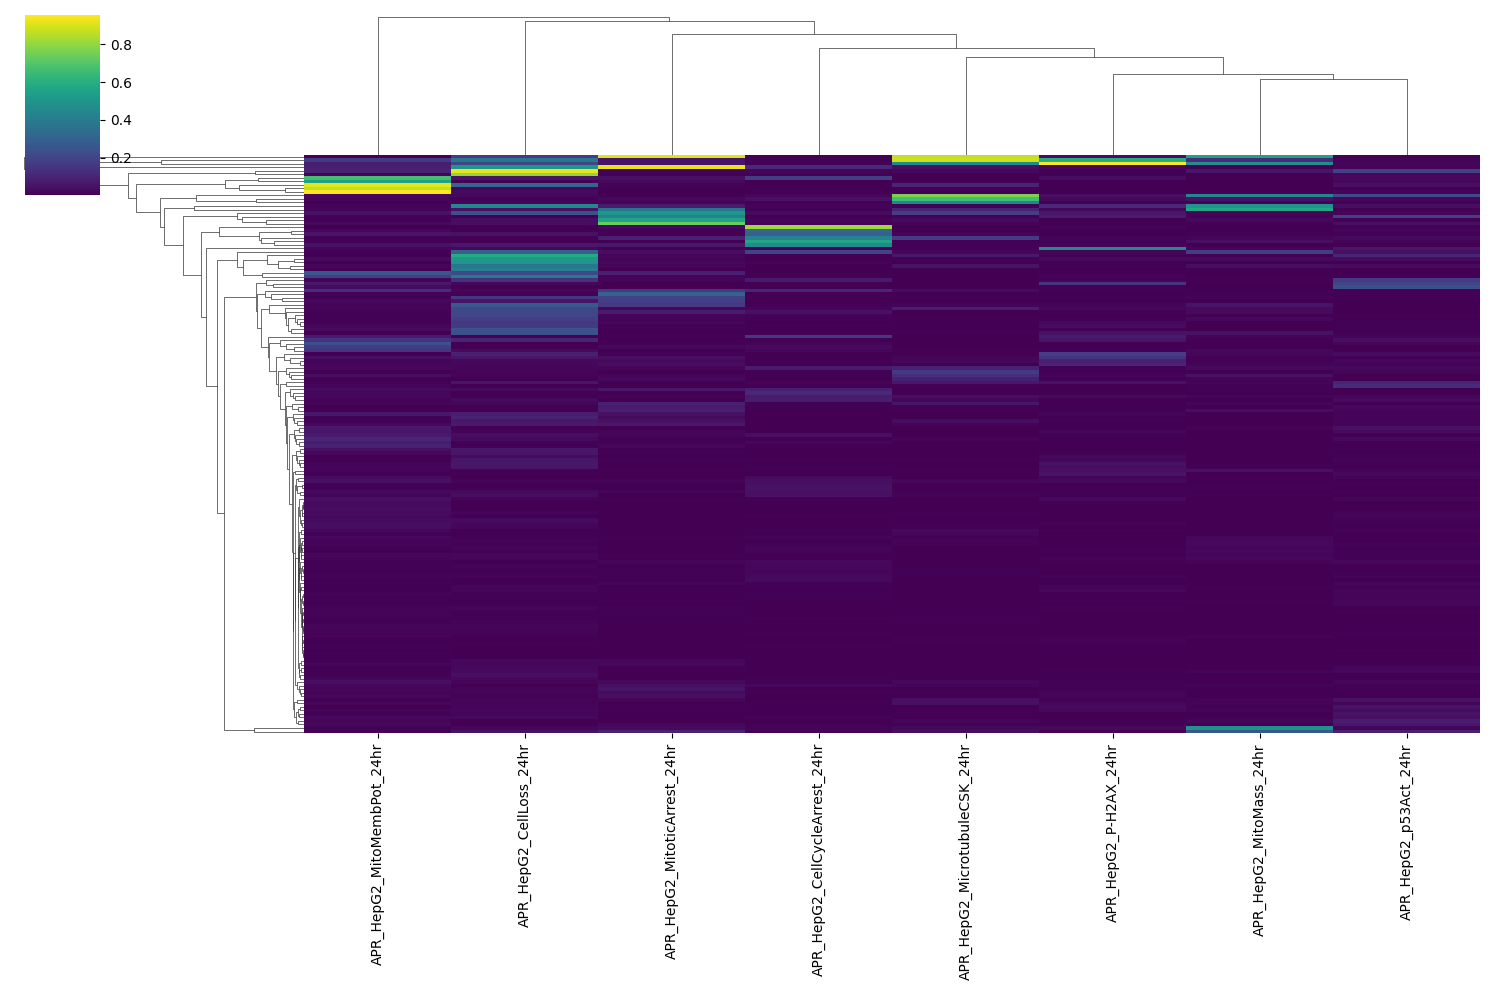

In [53]:
sns.clustermap(
    data_matrix,
    cmap="viridis",
    row_cluster=True,
    col_cluster=True,
    xticklabels=hepg2_morph_df.columns,
    yticklabels=False,
    figsize=(15, 10)
)
plt.show()

## Explore all different categories

In [6]:
cell_info = pl.read_parquet("../../1_snakemake/inputs/annotations/toxcast_cellbased_info.parquet").select([
    "assay_component_endpoint_name", "assay_component_desc", "tissue", "cell_short_name", 
    "intended_target_type", "intended_target_type_sub", "assay_function_type",
    "intended_target_family", "intended_target_family_sub"
]).unique()

In [7]:
cell_df = pred_df.rename({"Metadata_Label": "assay_component_endpoint_name"})
cell_df = cell_info.join(cell_df, on="assay_component_endpoint_name", how="inner")
cell_df = cell_df.with_columns((pl.col("Metadata_Count_1")/pl.col("Total_Compounds")).alias("Percent_positive"))
cell_df

assay_component_endpoint_name,assay_component_desc,tissue,cell_short_name,intended_target_type,intended_target_type_sub,assay_function_type,intended_target_family,intended_target_family_sub,Metadata_AggType,Model_type,AUROC,PRAUC,Metadata_Count_0,Metadata_Count_1,Feat_type,Total_Compounds,Endpoint_type,Percent_positive
str,str,str,str,str,str,str,str,str,str,str,f64,f64,i32,i32,str,i32,str,f64
"""LTEA_HepaRG_CYP2B6""","""LTEA_HepaRG_CYP2B6 is one of 1…","""liver""","""HepaRG""","""rna""","""mRNA""","""reporter gene""","""cyp""","""xenobiotic metabolism""","""all""","""Actual""",0.554763,0.429591,103,64,"""cellprofiler""",167,"""toxcast_cellbased""",0.383234
"""LTEA_HepaRG_CYP3A4""","""LTEA_HepaRG_CYP3A4 is one of 1…","""liver""","""HepaRG""","""rna""","""mRNA""","""reporter gene""","""cyp""","""xenobiotic metabolism""","""all""","""Actual""",0.461743,0.178776,133,34,"""cellprofiler""",167,"""toxcast_cellbased""",0.203593
"""OT_FXR_FXRSRC1_0480""","""OT_FXR_FXRSRC1_0480 is one of …","""kidney""","""HEK293T""","""pathway""","""pathway-specified""","""binding""","""nuclear receptor""","""non-steroidal""","""all""","""Actual""",0.358848,0.128258,178,24,"""cellprofiler""",202,"""toxcast_cellbased""",0.118812
"""ATG_CRE_CIS""","""ATG_CRE_CIS is one of 52 assay…","""liver""","""HepG2""","""protein""","""transcription factor""","""reporter gene""","""dna binding""","""basic leucine zipper""","""all""","""Actual""",0.659457,0.072299,284,14,"""cellprofiler""",298,"""toxcast_cellbased""",0.04698
"""CEETOX_H295R_TESTO""","""CEETOX_H295R_TESTO is one of 2…","""adrenal gland""","""H295R""","""molecular messenger""","""Testosterone""","""detection of steroid hormone""","""steroid hormone""","""androgens""","""all""","""Actual""",0.489564,0.239746,62,17,"""cellprofiler""",79,"""toxcast_cellbased""",0.21519
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""TOX21_ERa_BLA_Agonist_ratio""","""TOX21_ERa_BLA_Agonist_ratio is…","""kidney""","""HEK293T""","""protein""","""receptor""","""ratio""","""nuclear receptor""","""steroidal""","""all""","""Actual""",0.538054,0.060386,632,20,"""cellprofiler""",652,"""toxcast_cellbased""",0.030675
"""APR_HepG2_MitoticArrest_24hr""","""APR_HepG2_MitoticArrest_24hr i…","""liver""","""HepG2""","""pathway""","""pathway-specified""","""signaling""","""cell cycle""","""arrest""","""all""","""Actual""",0.485577,0.050343,156,8,"""cellprofiler""",164,"""toxcast_cellbased""",0.04878
"""TOX21_ERb_BLA_Agonist_ratio""","""TOX21_ERb_BLA_Agonist_ratio is…","""kidney""","""HEK293T""","""protein""","""receptor""","""ratio""","""nuclear receptor""","""steroidal""","""all""","""Actual""",0.406445,0.015575,584,11,"""cellprofiler""",595,"""toxcast_cellbased""",0.018487


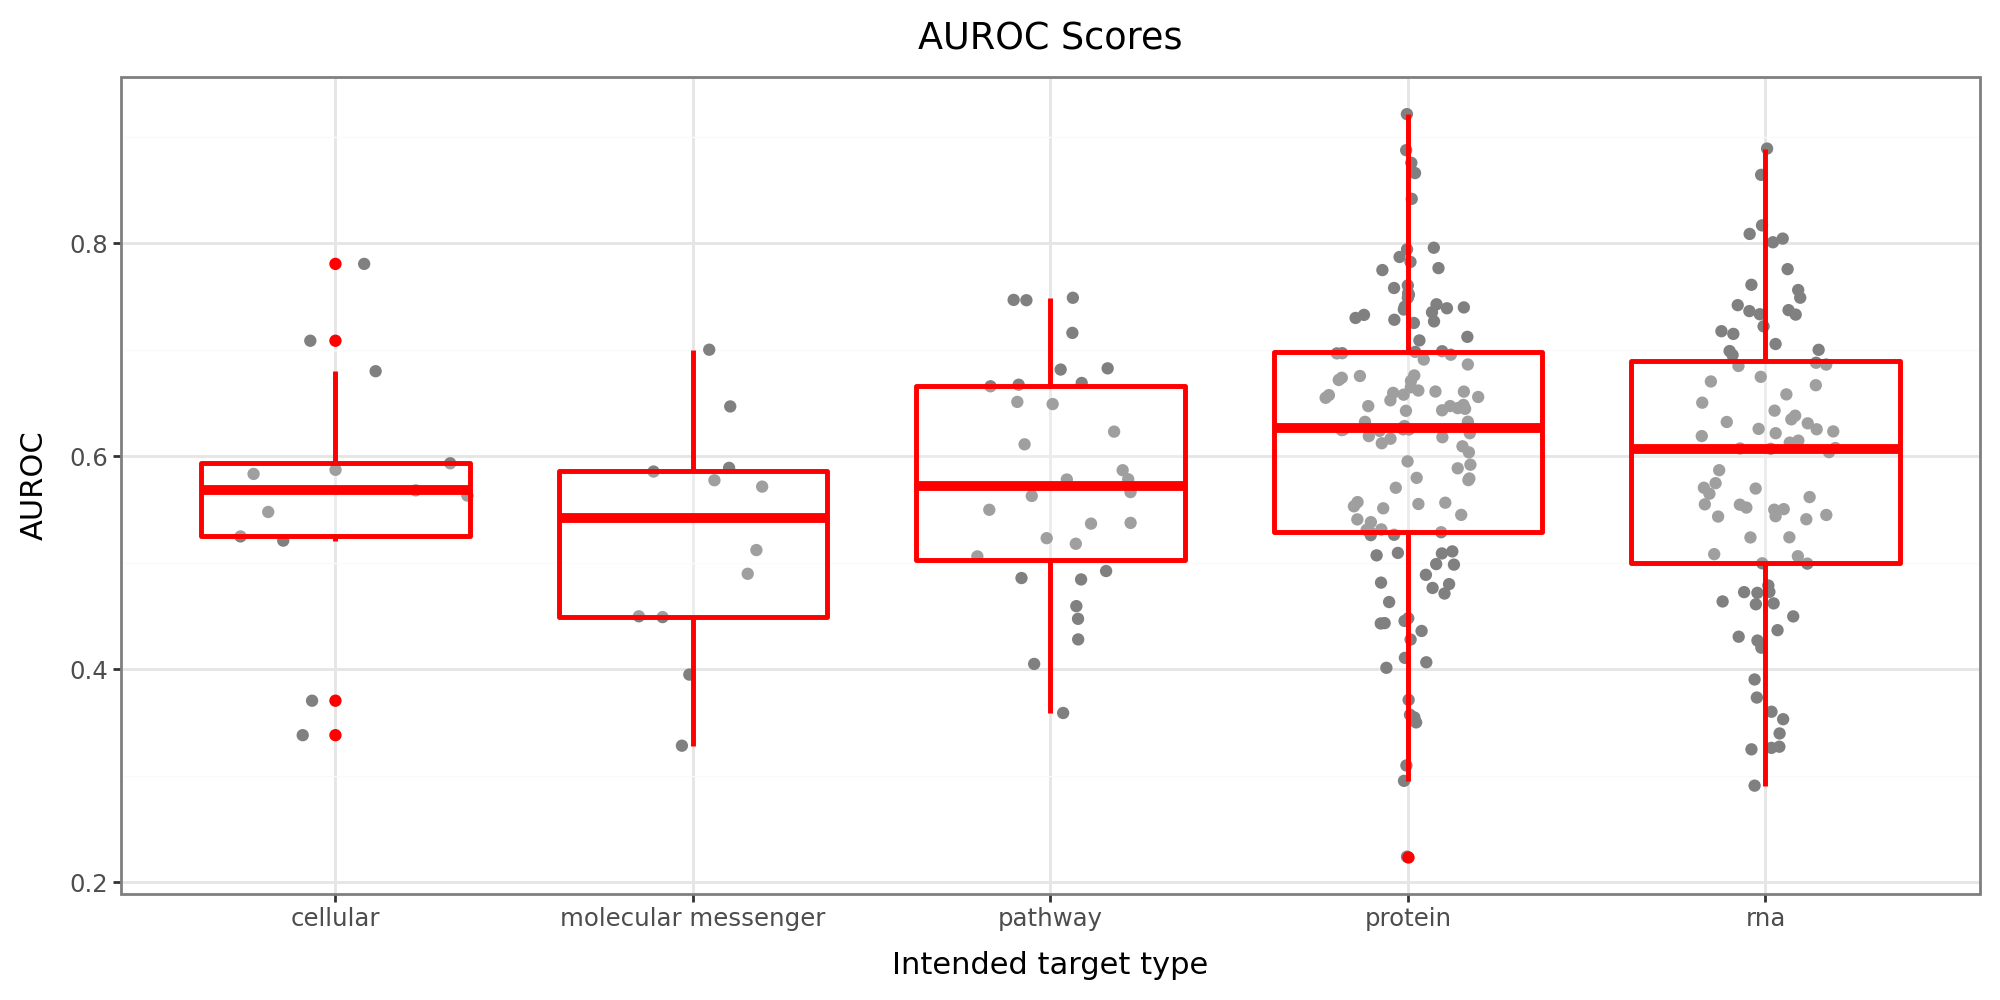

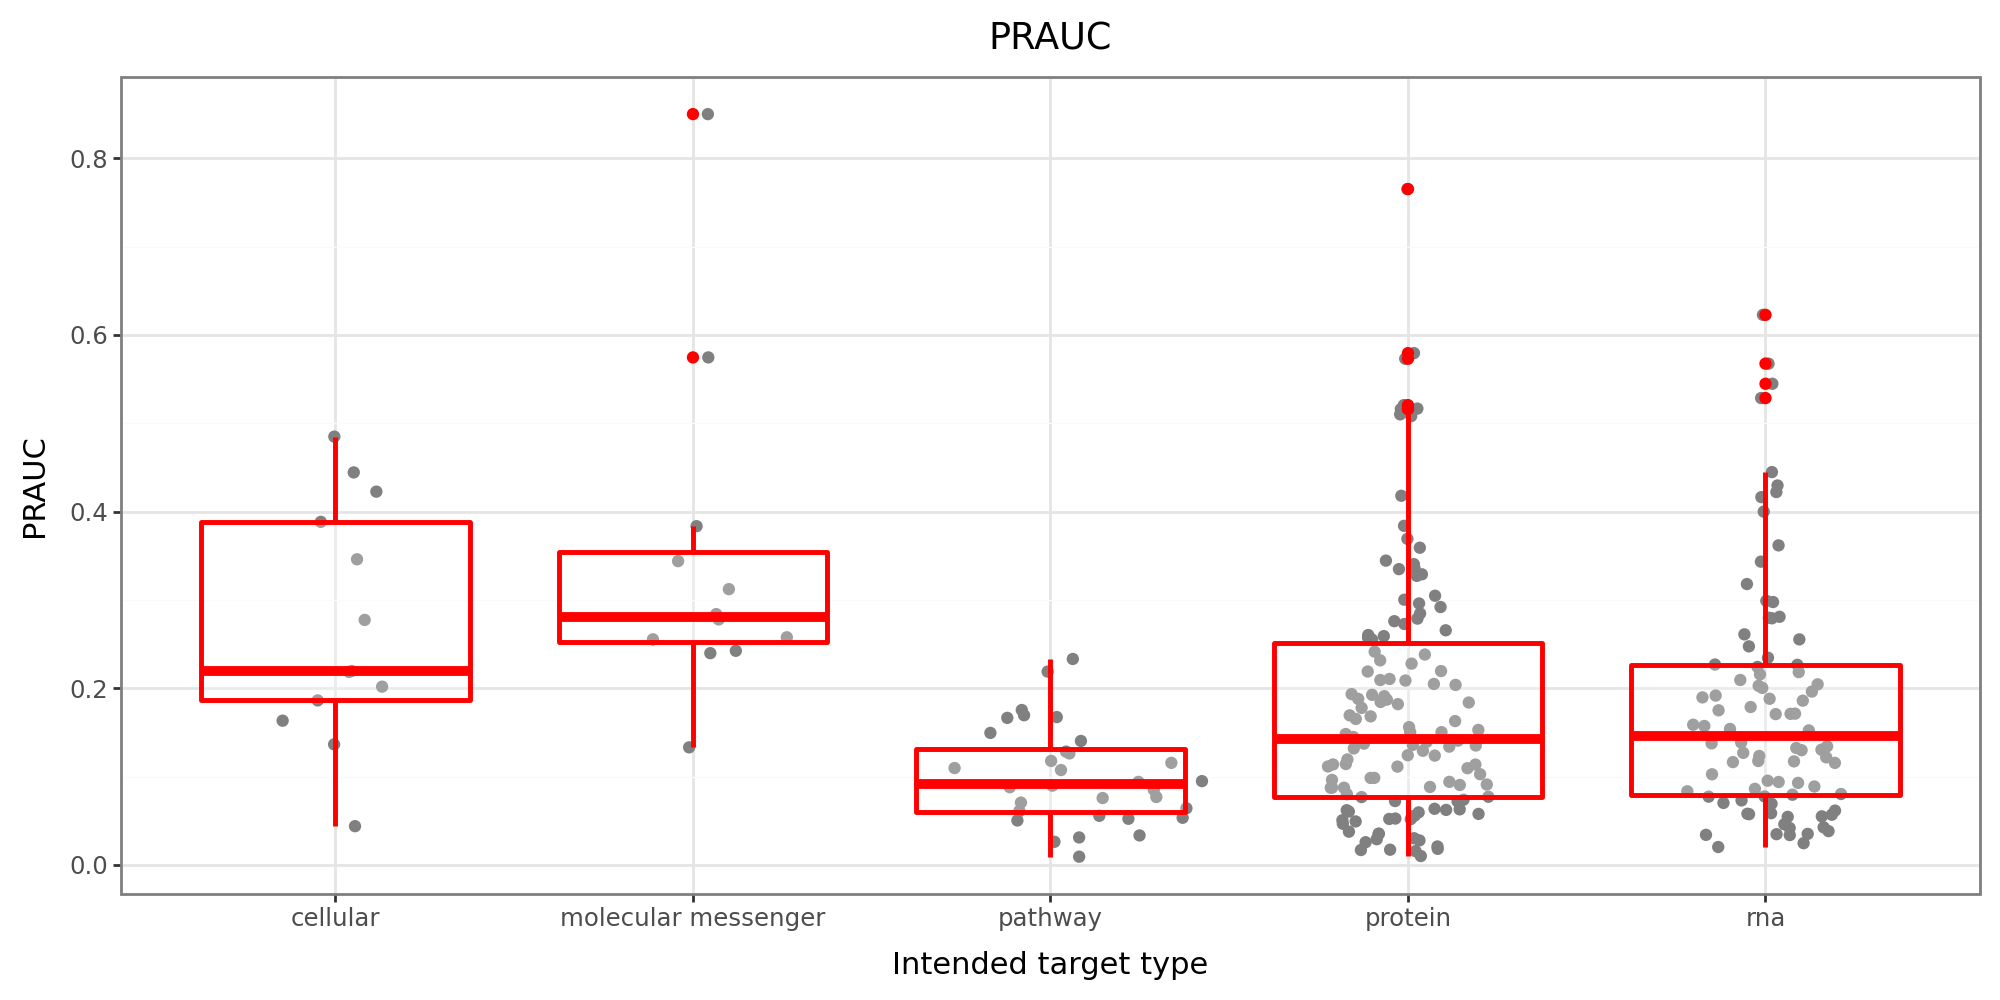

In [8]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(cell_df, aes(x='intended_target_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores', x='Intended target type', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(cell_df, aes(x='intended_target_type', y='PRAUC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='PRAUC', x='Intended target type', y='PRAUC') 
    + theme_bw()
)
plot.show()

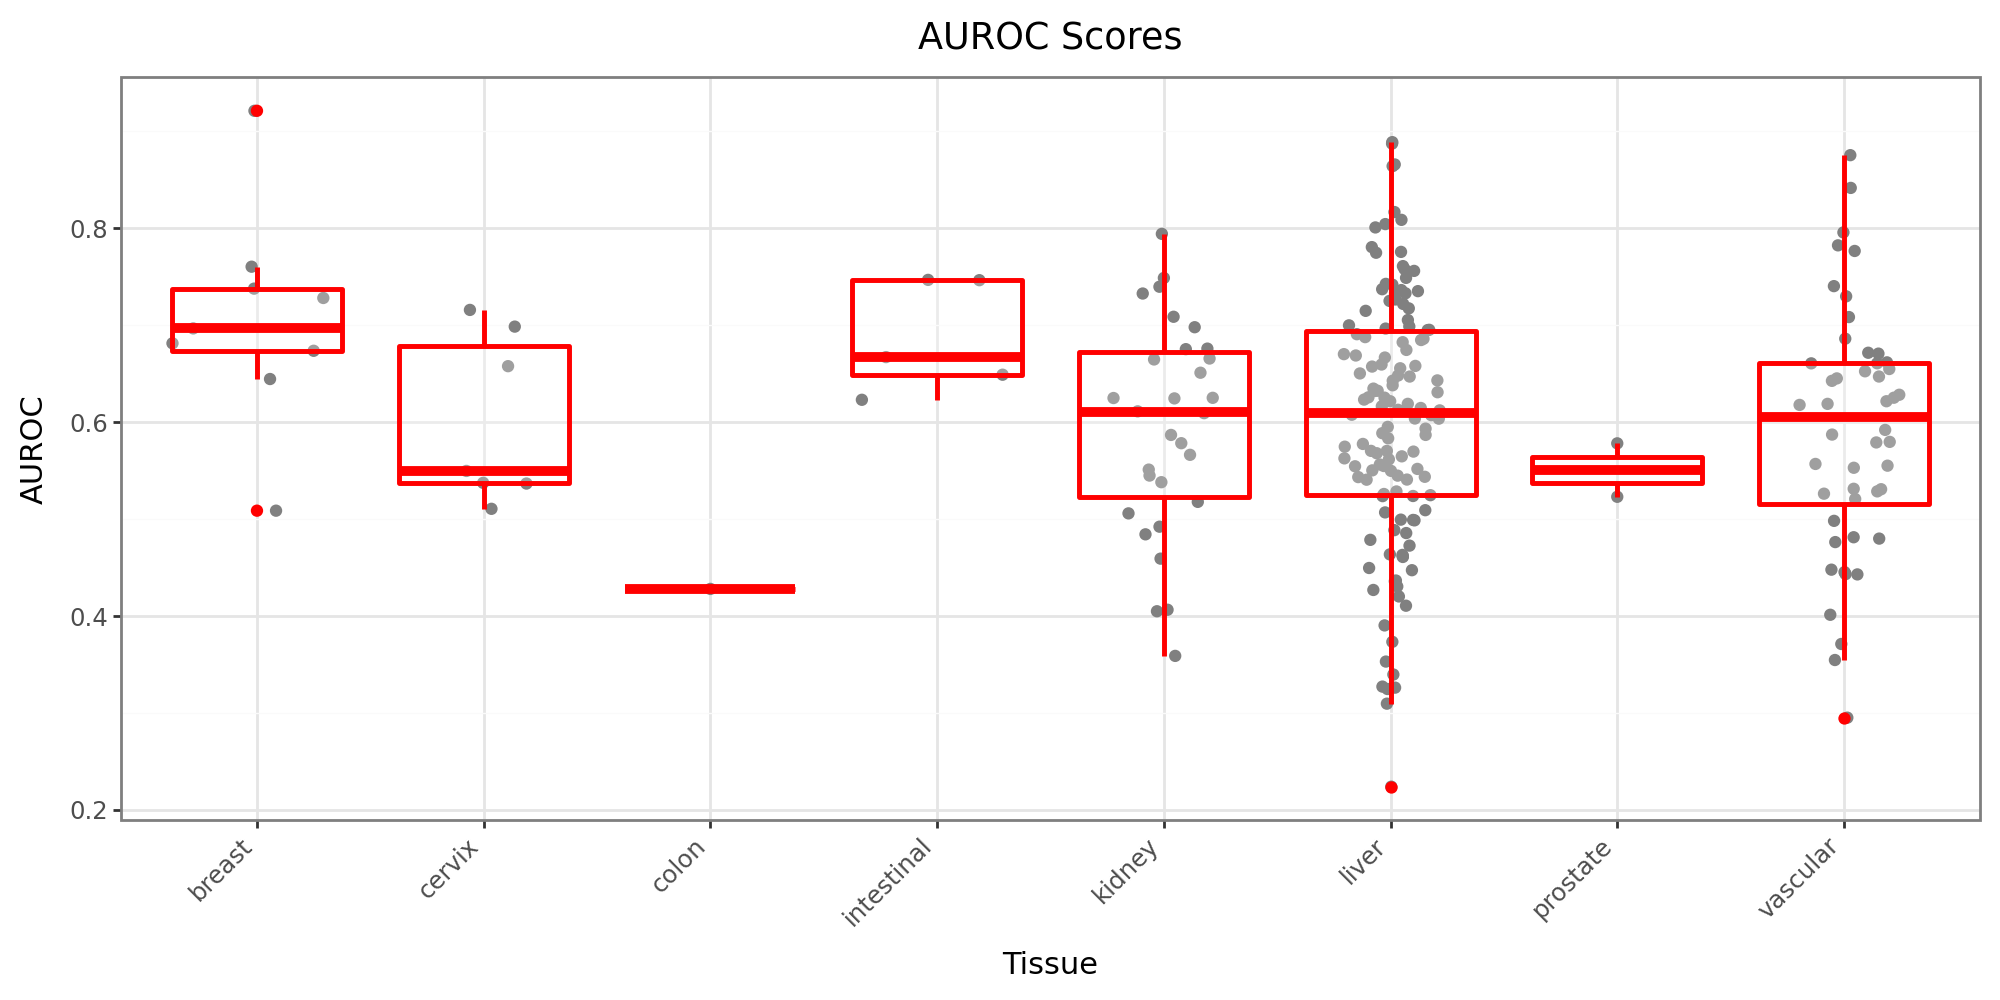

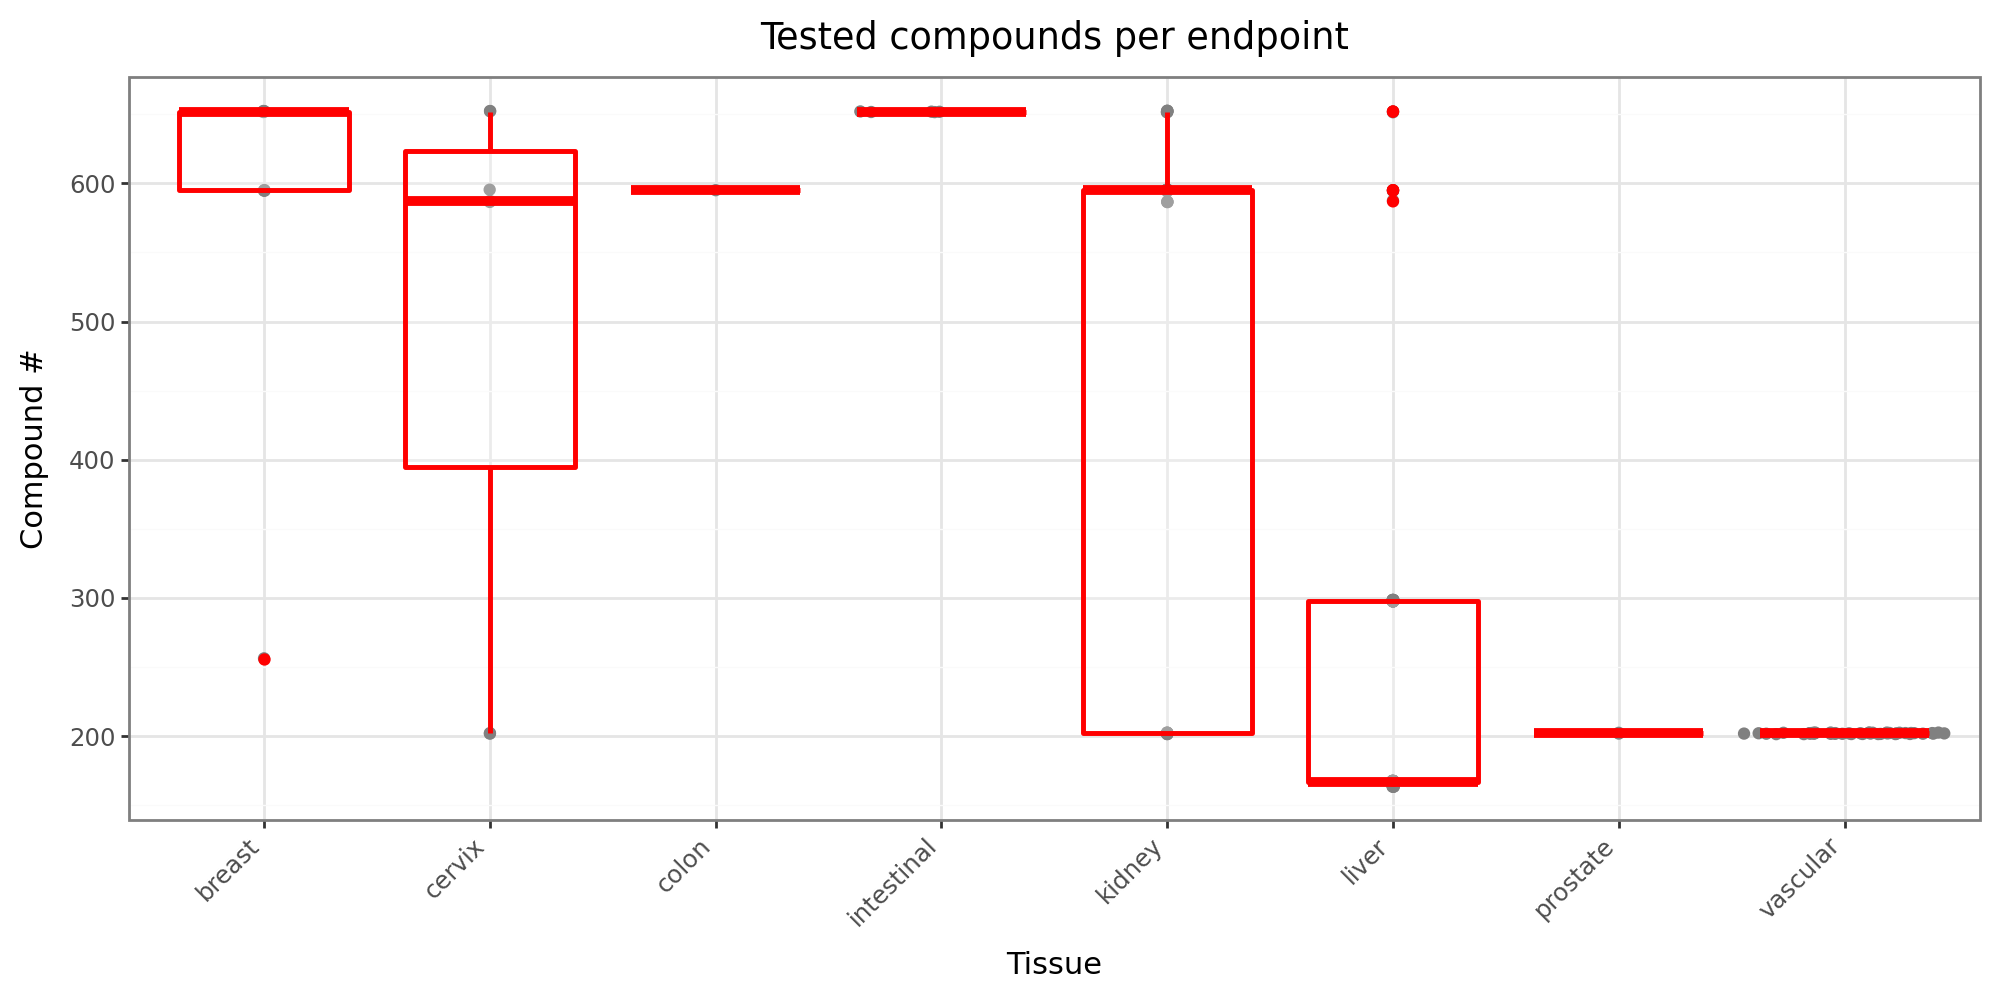

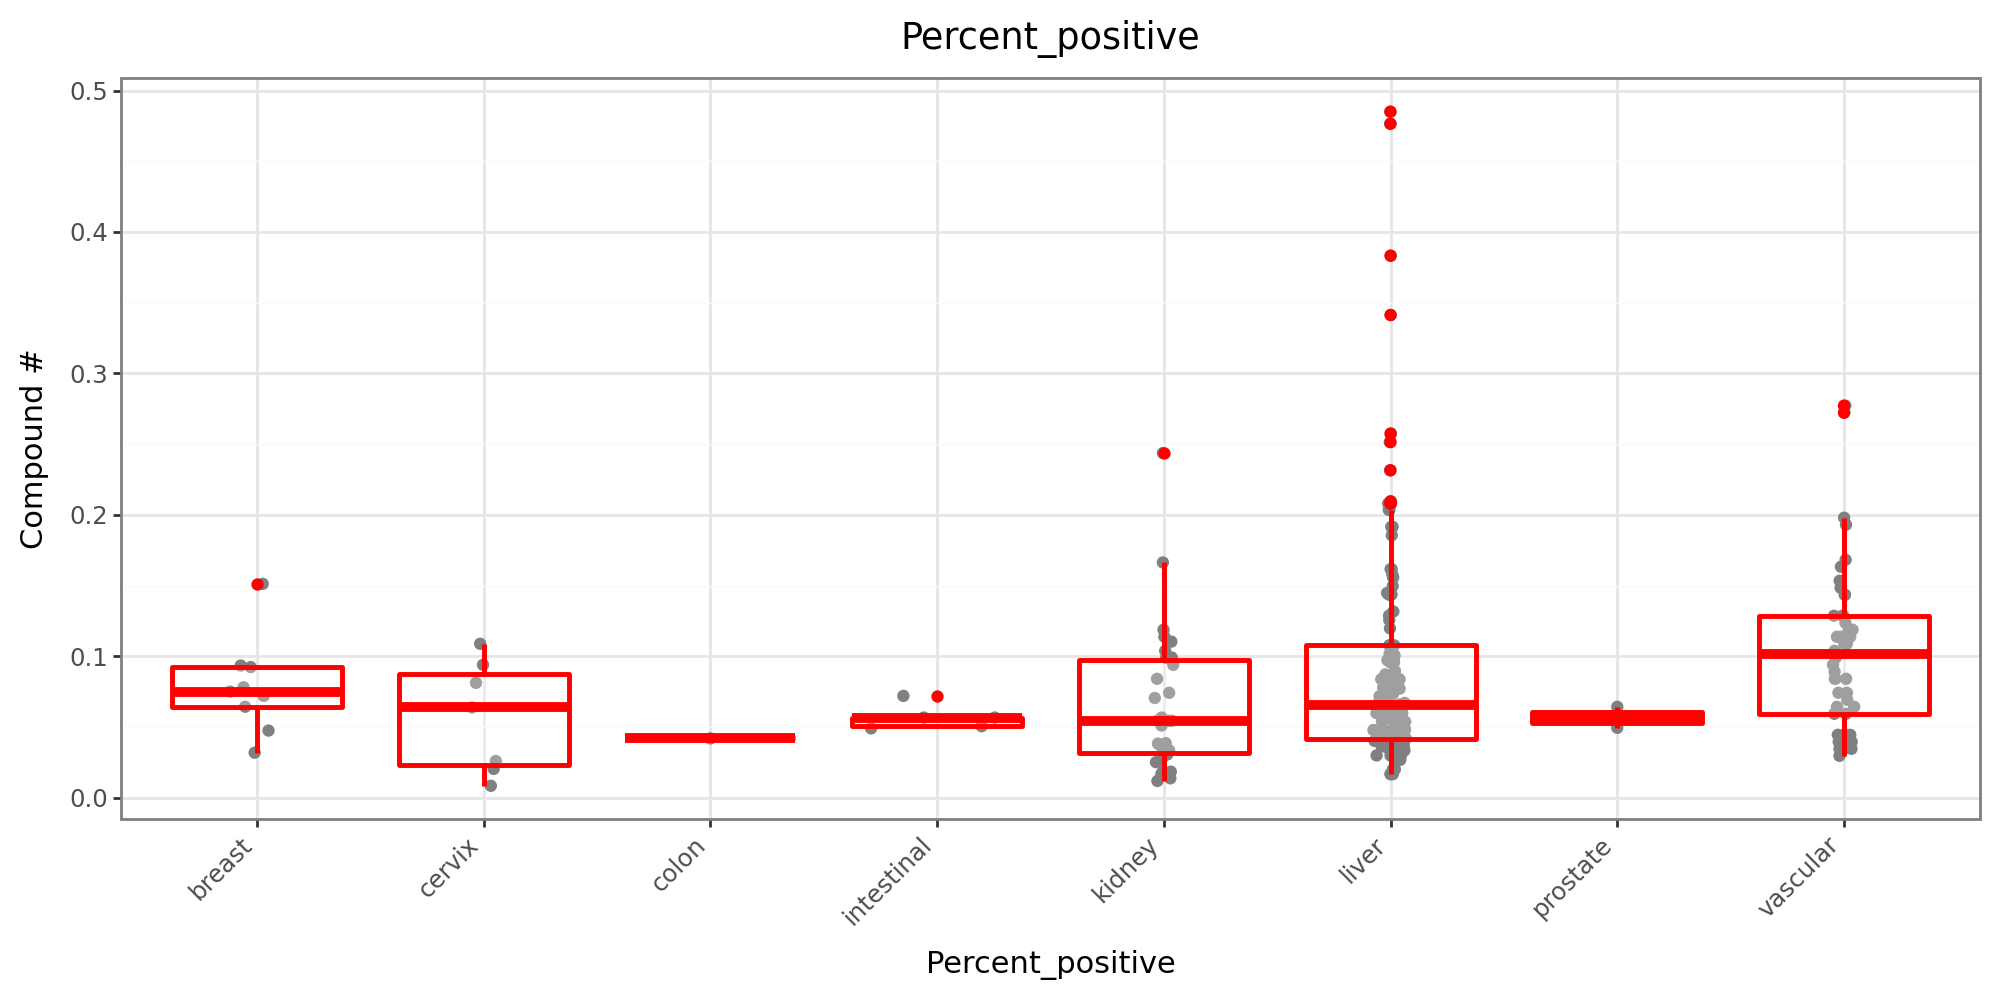

In [9]:
tissue_df = cell_df.filter(
    pl.col("Total_Compounds") > 100
)

from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_wrap, theme, element_text
import plotnine as pn

pn.options.figure_size = (10, 5)

plot = (
    ggplot(tissue_df, aes(x='tissue', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='AUROC Scores', x='Tissue', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(tissue_df, aes(x='tissue', y='Total_Compounds')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Tested compounds per endpoint', x='Tissue', y='Compound #') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(tissue_df, aes(x='tissue', y='Percent_positive')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Percent_positive', x='Percent_positive', y='Compound #') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

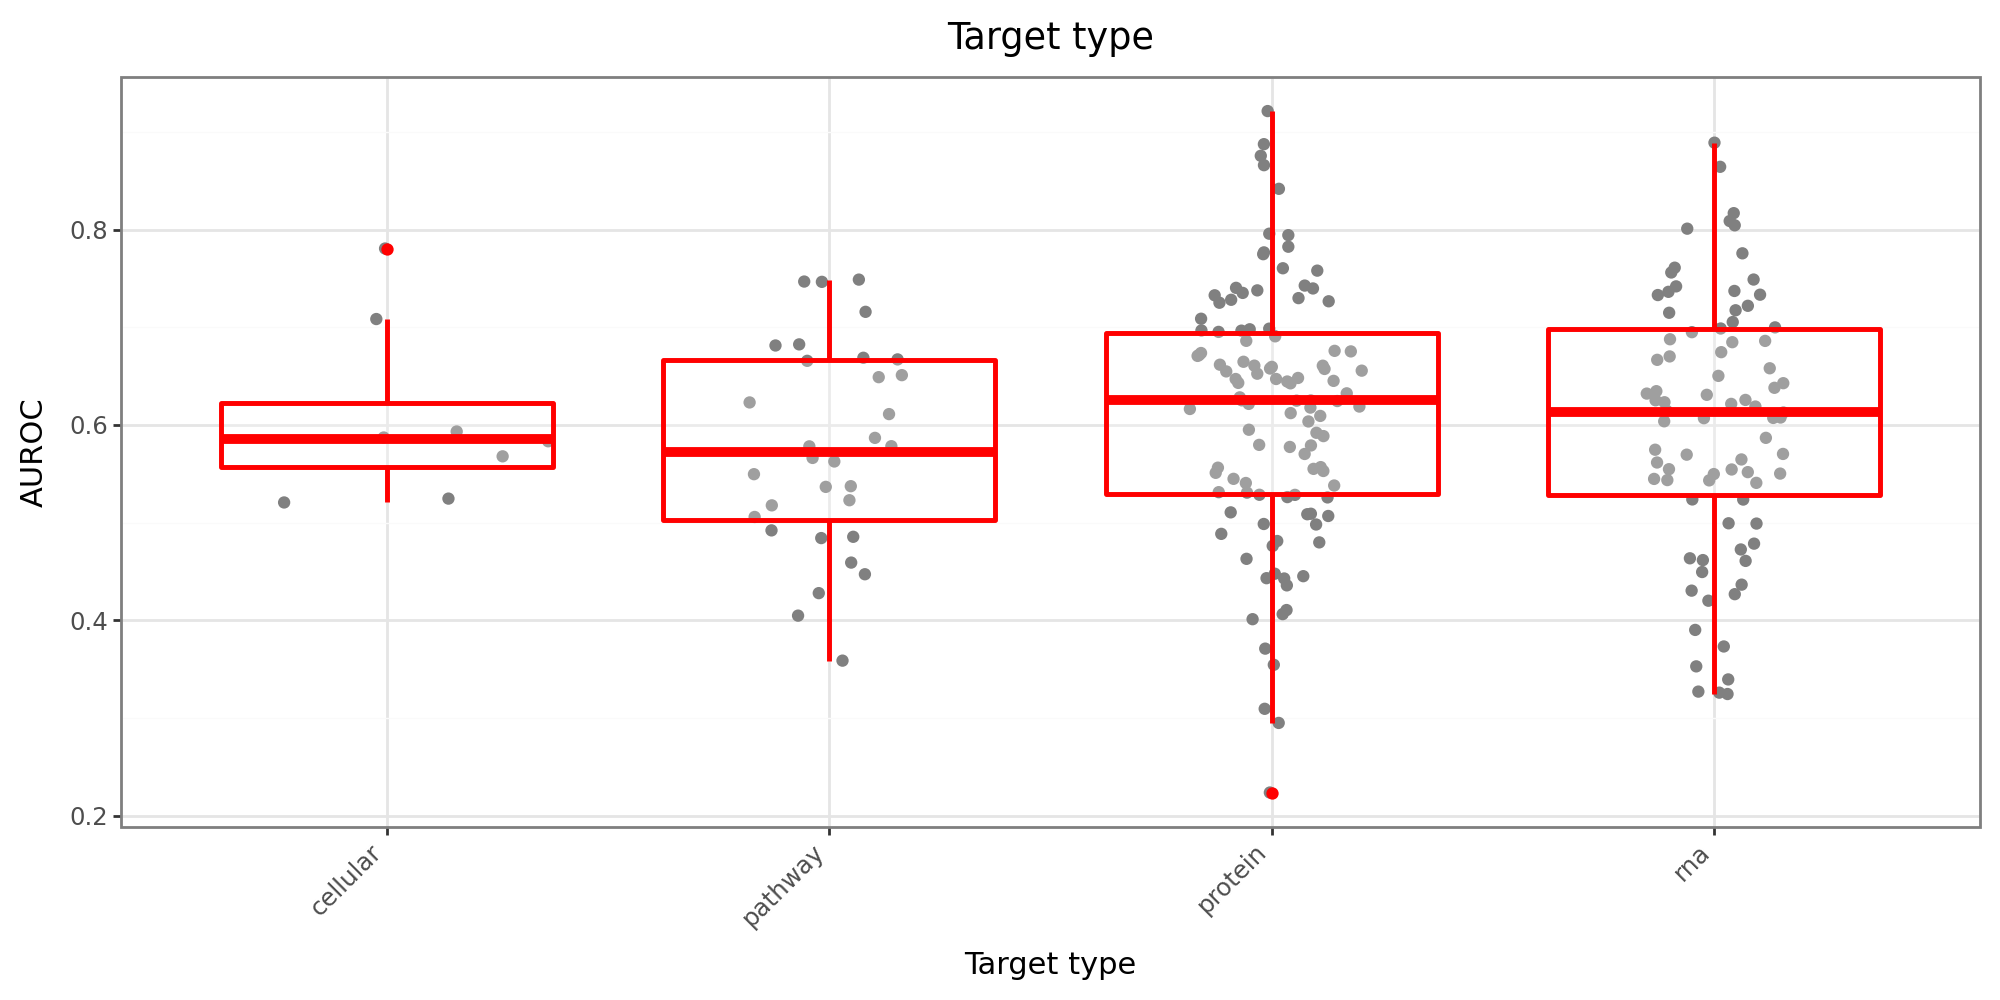

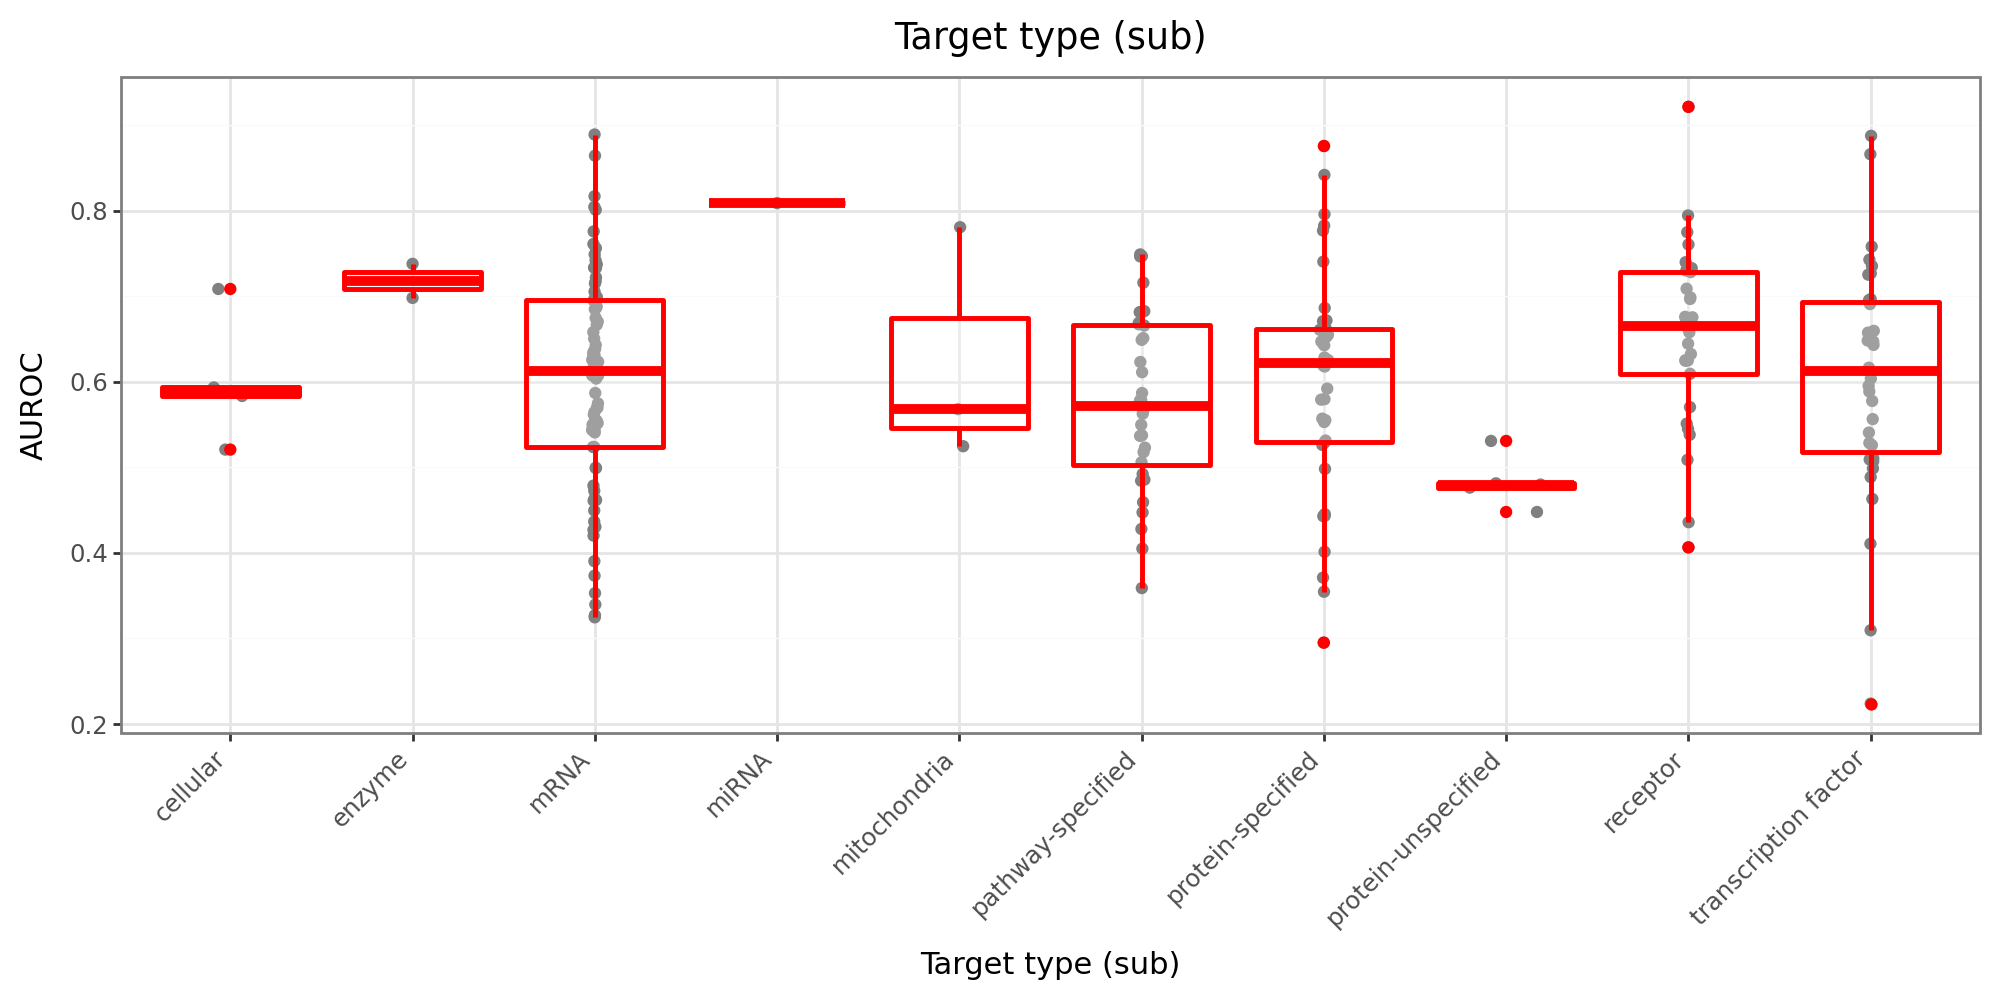

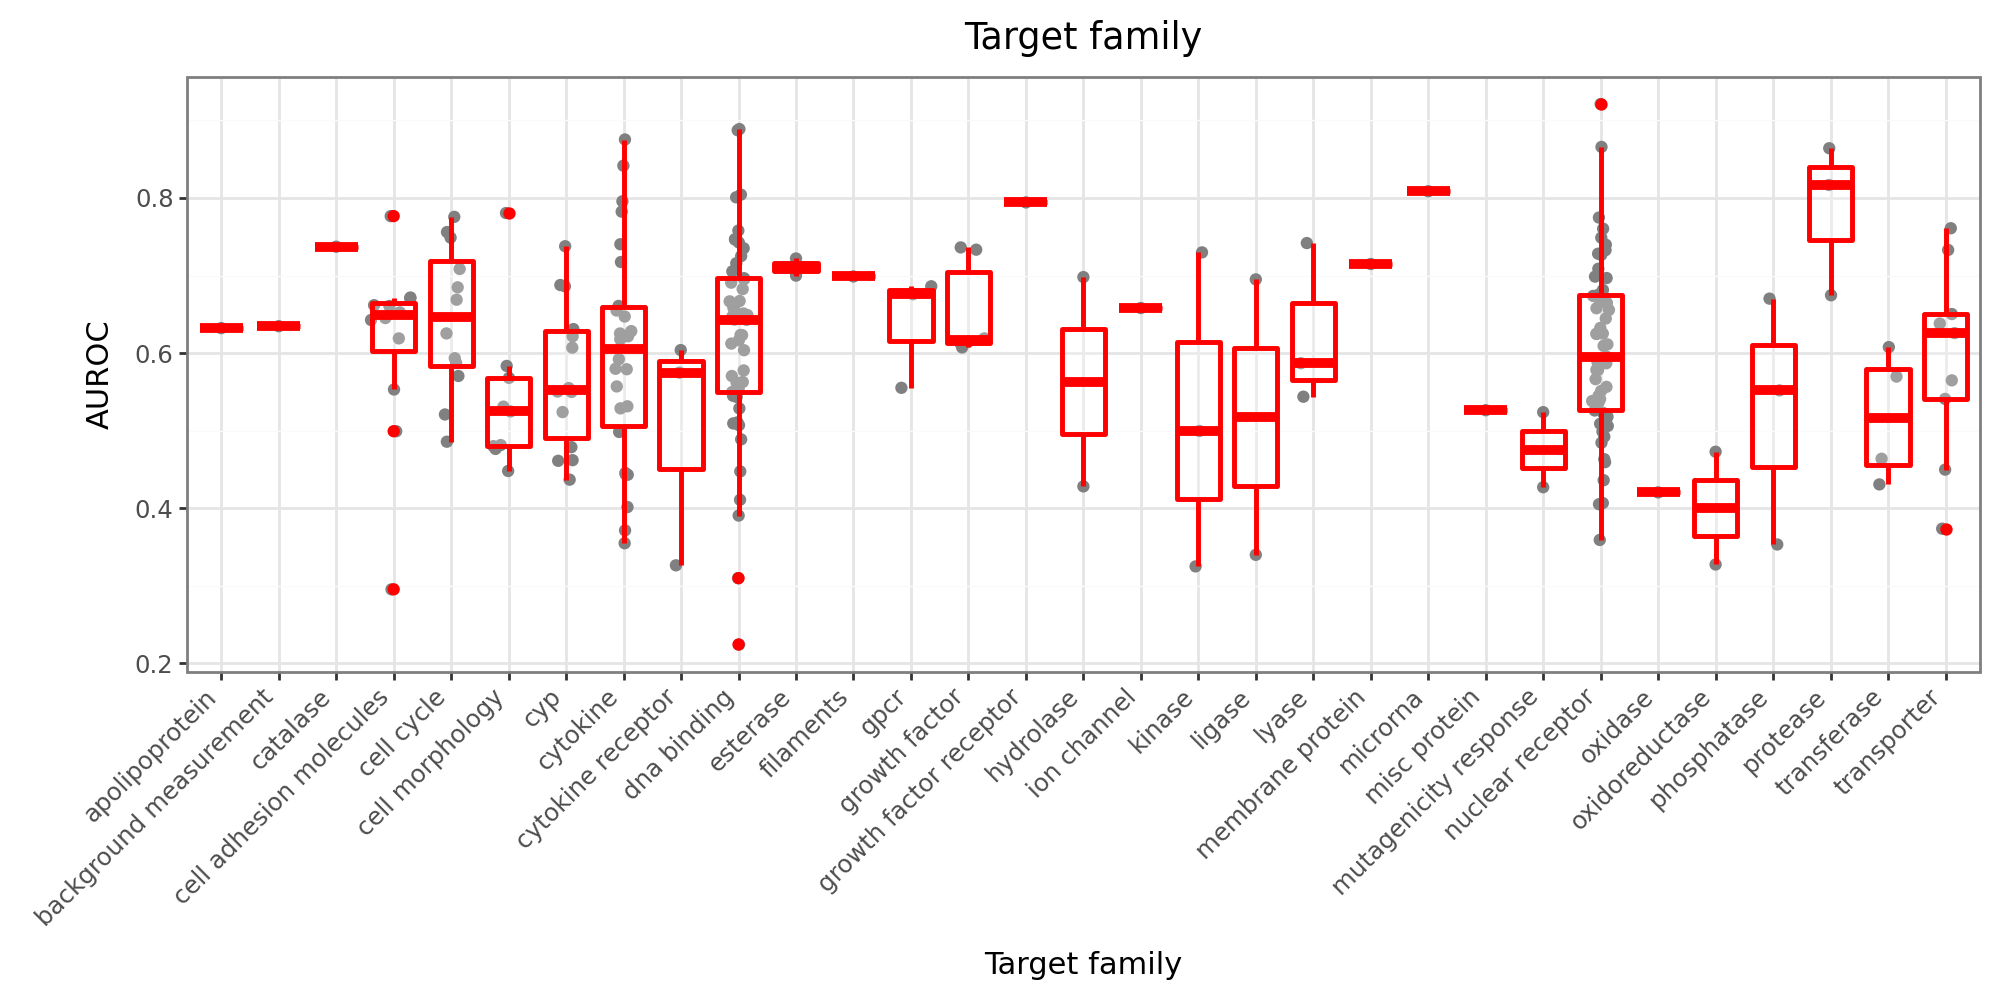

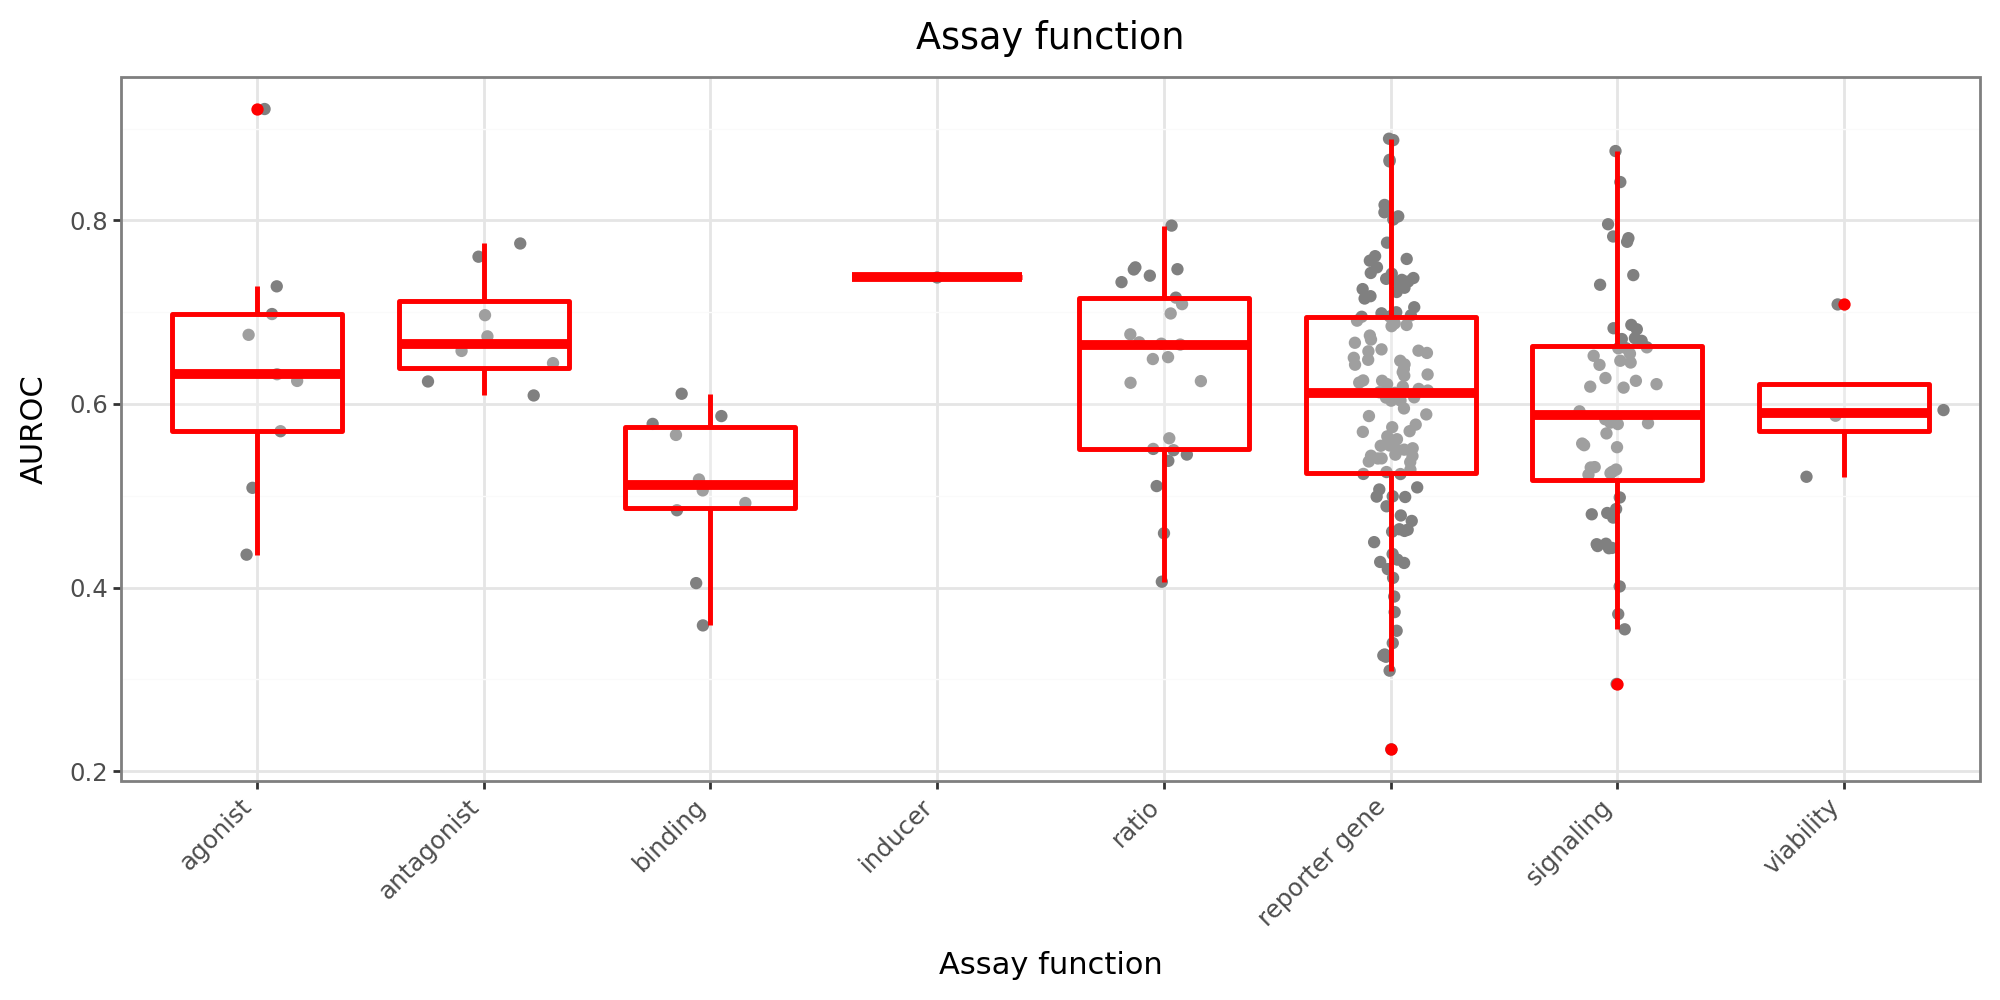

In [10]:
plot = (
    ggplot(tissue_df, aes(x='intended_target_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target type', x='Target type', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()


plot = (
    ggplot(tissue_df, aes(x='intended_target_type_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target type (sub)', x='Target type (sub)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()


plot = (
    ggplot(tissue_df, aes(x='intended_target_family', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family', x='Target family', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(tissue_df, aes(x='assay_function_type', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Assay function', x='Assay function', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

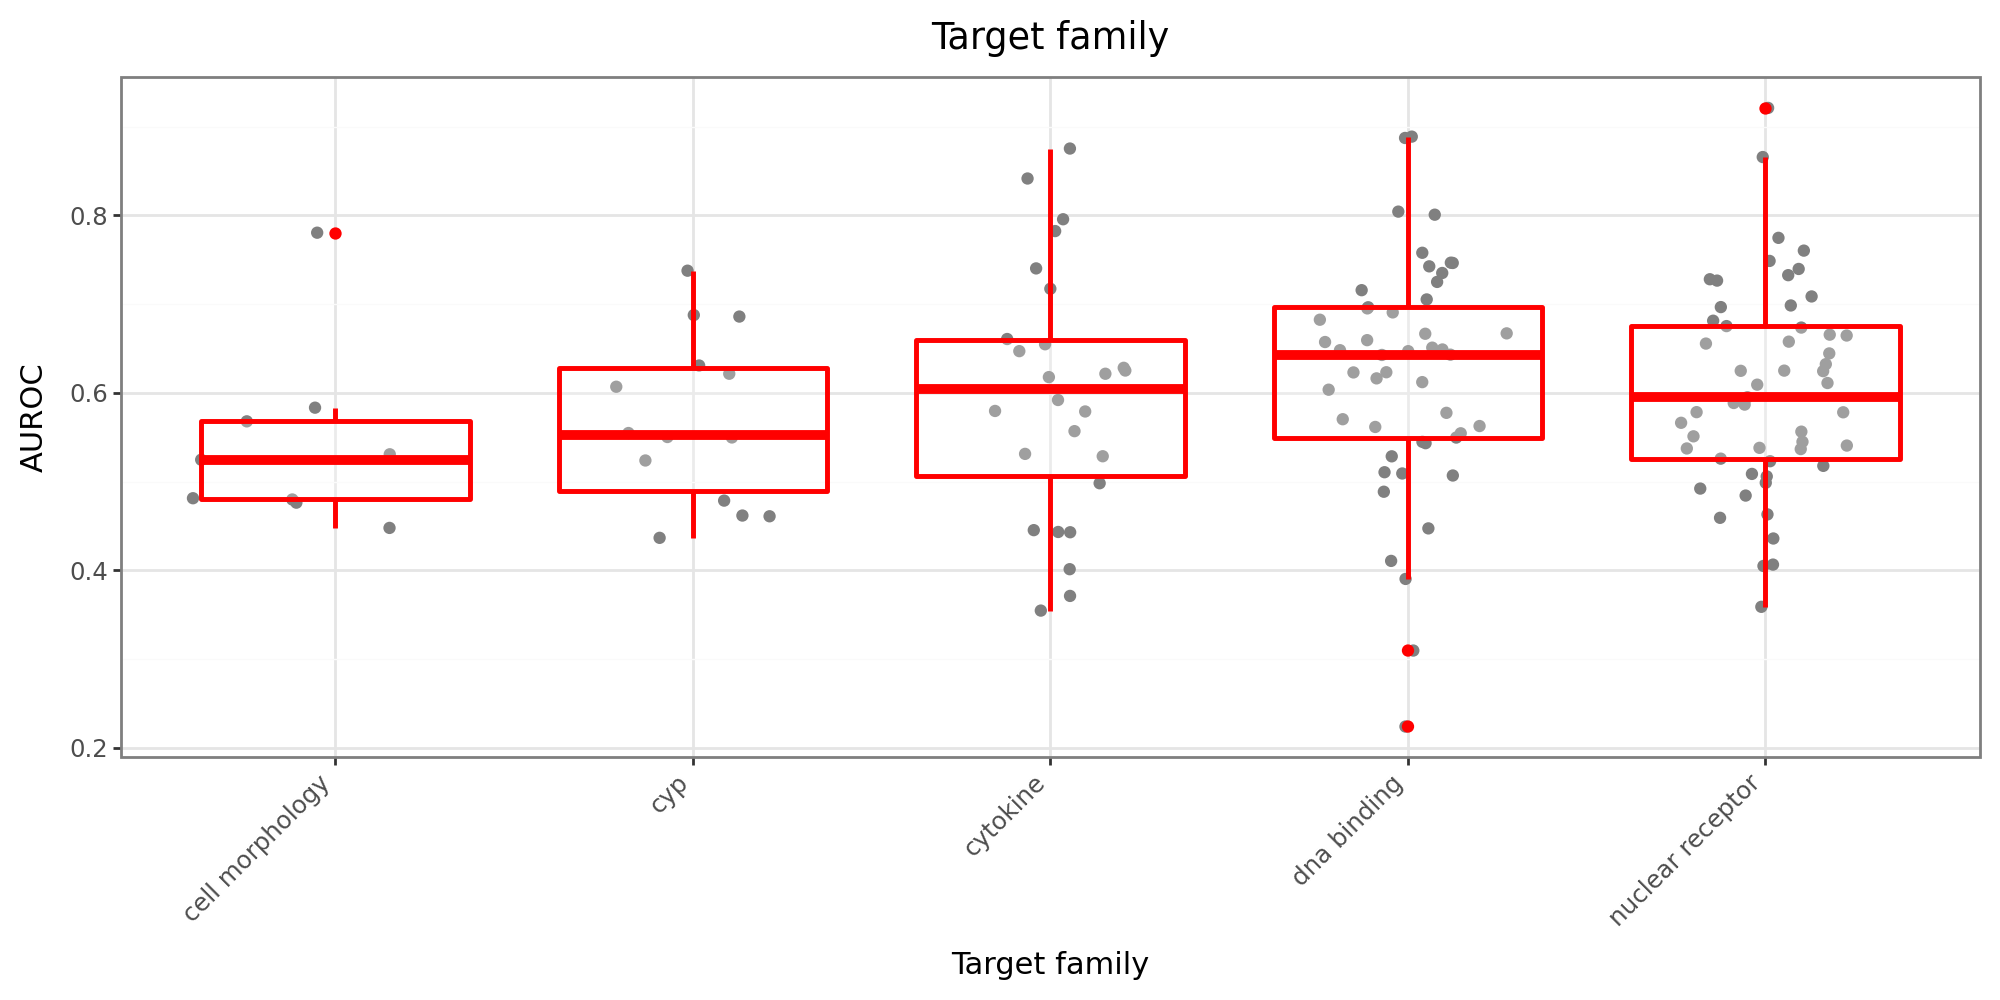

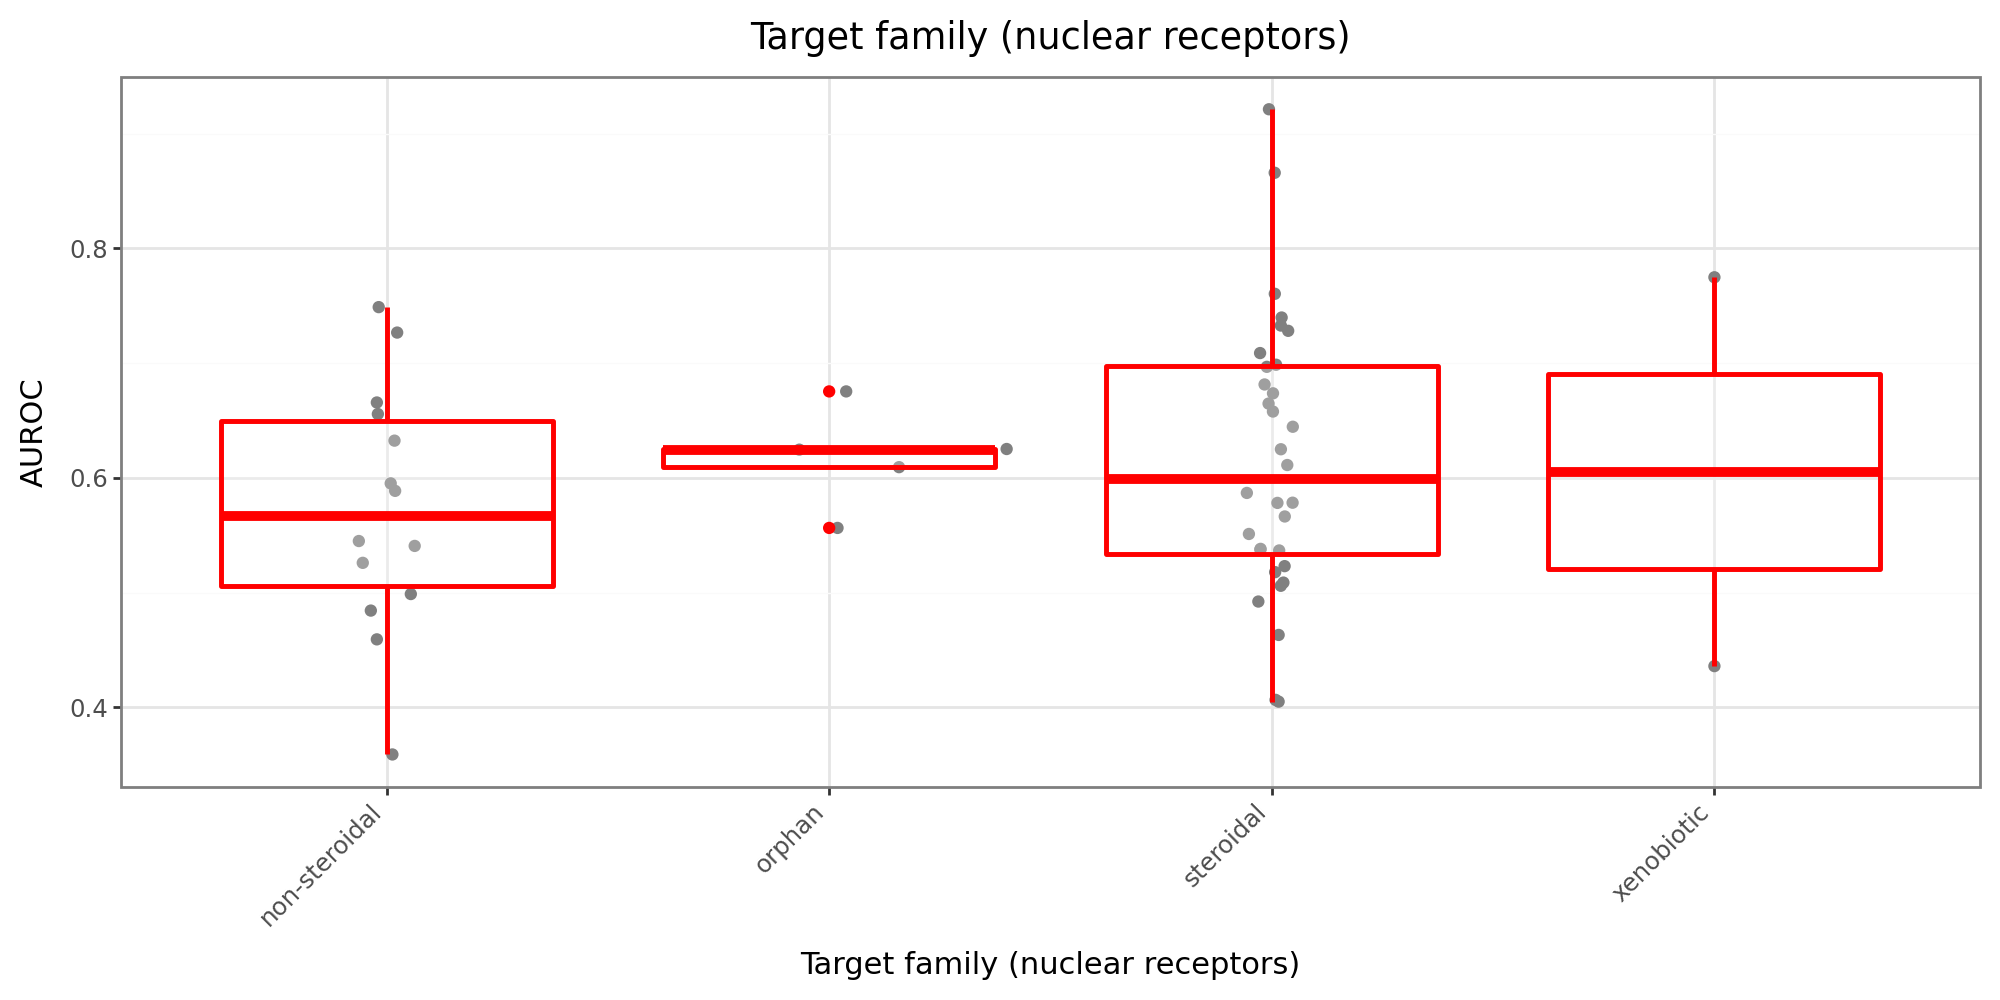

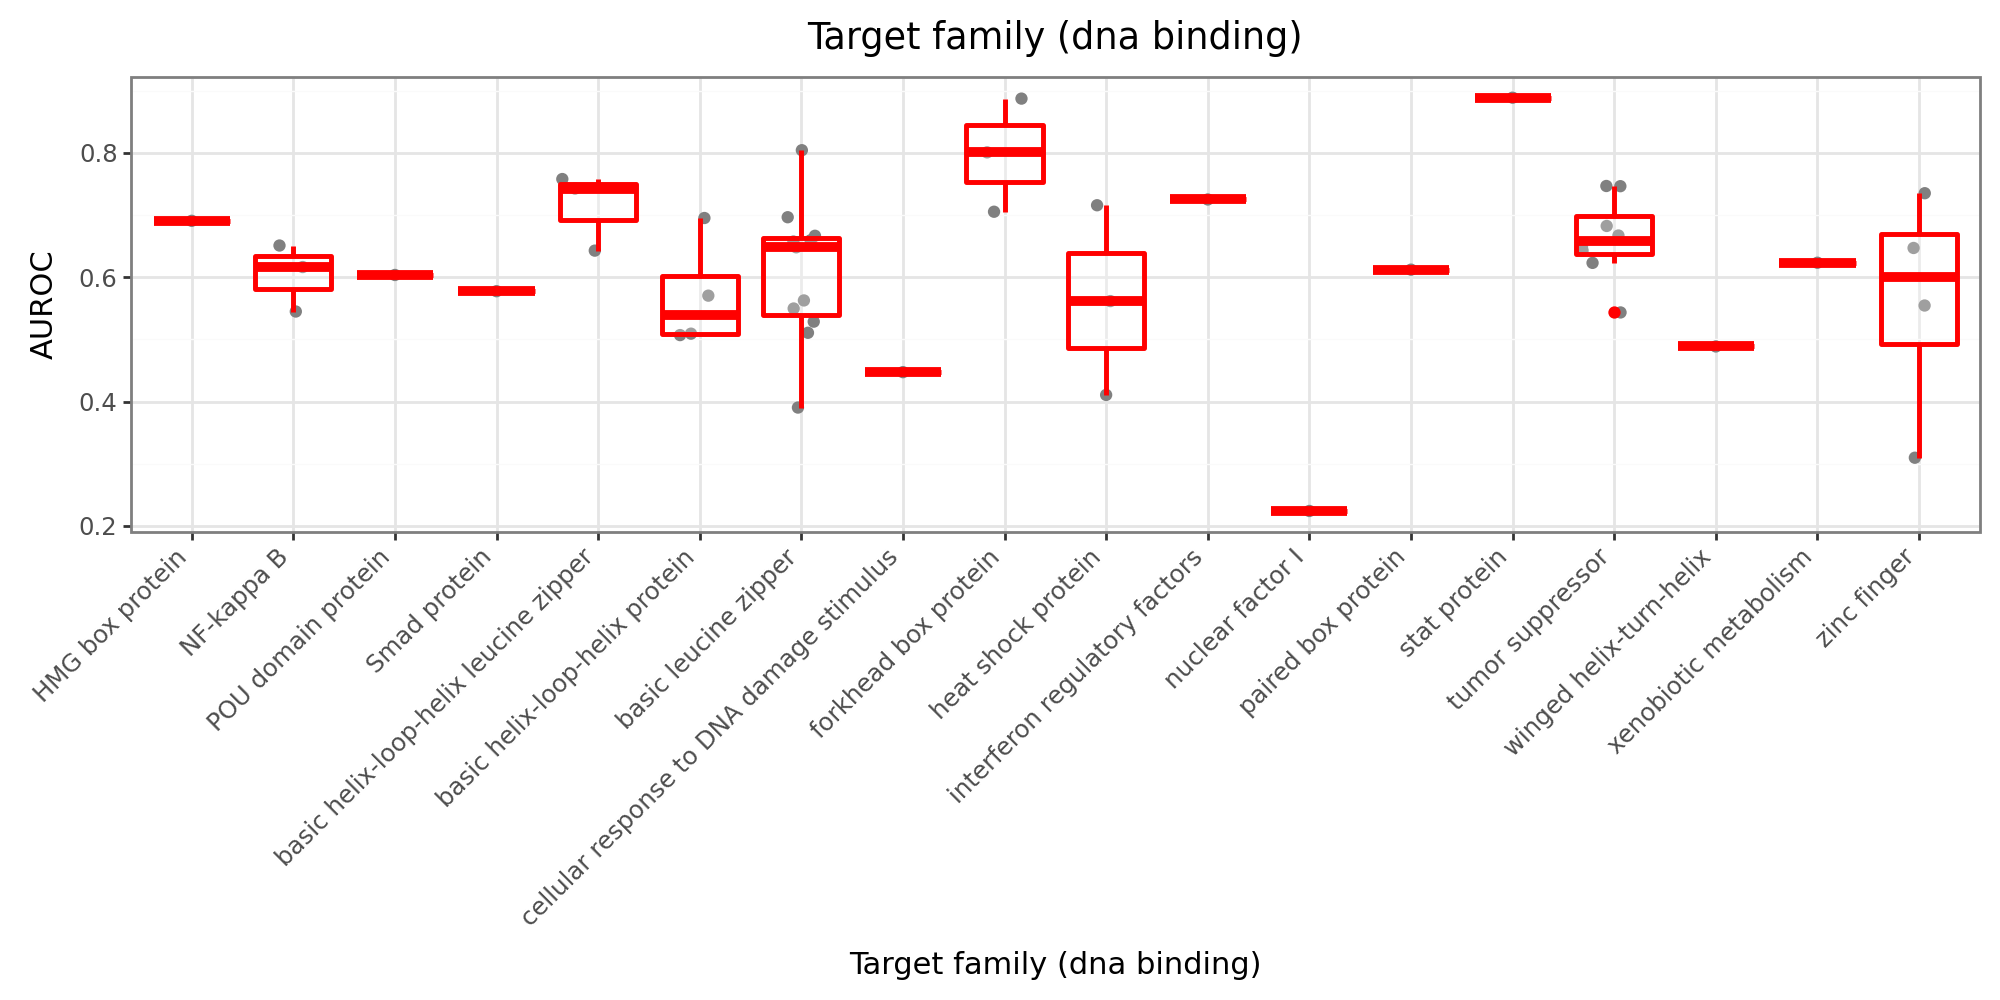

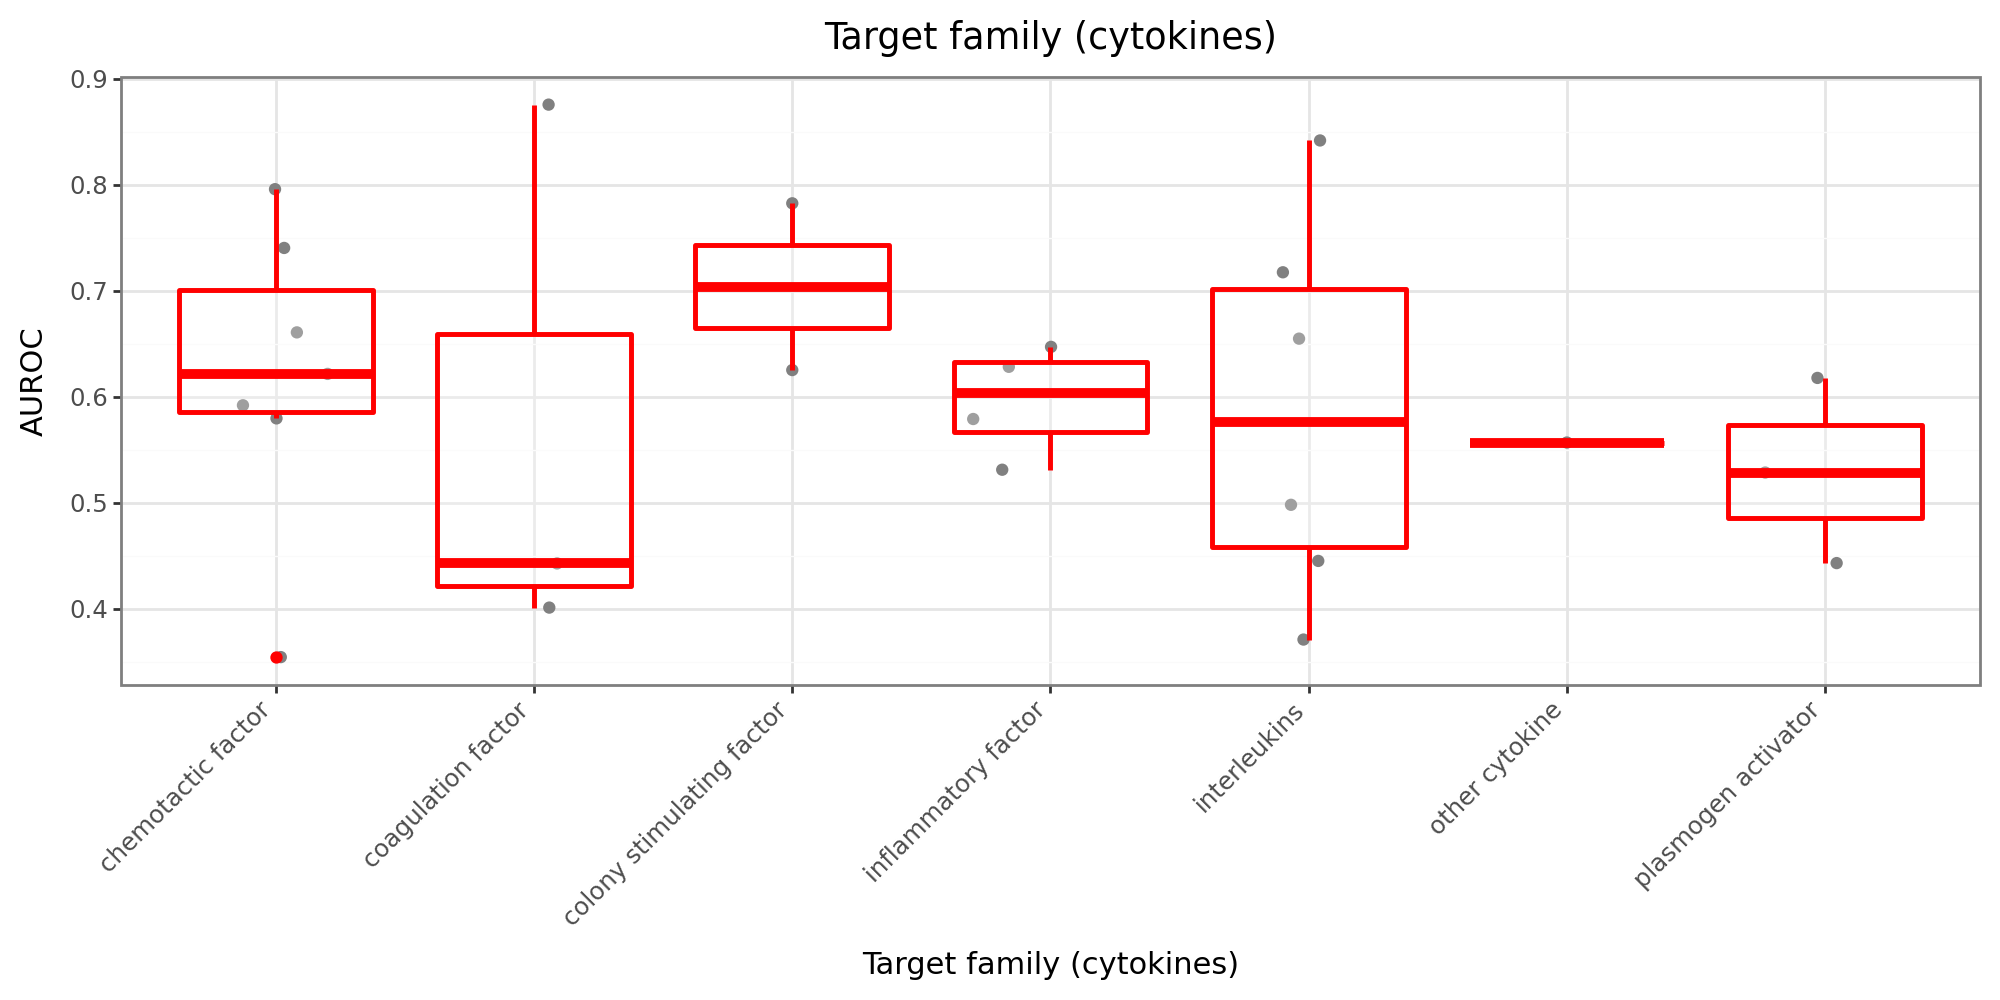

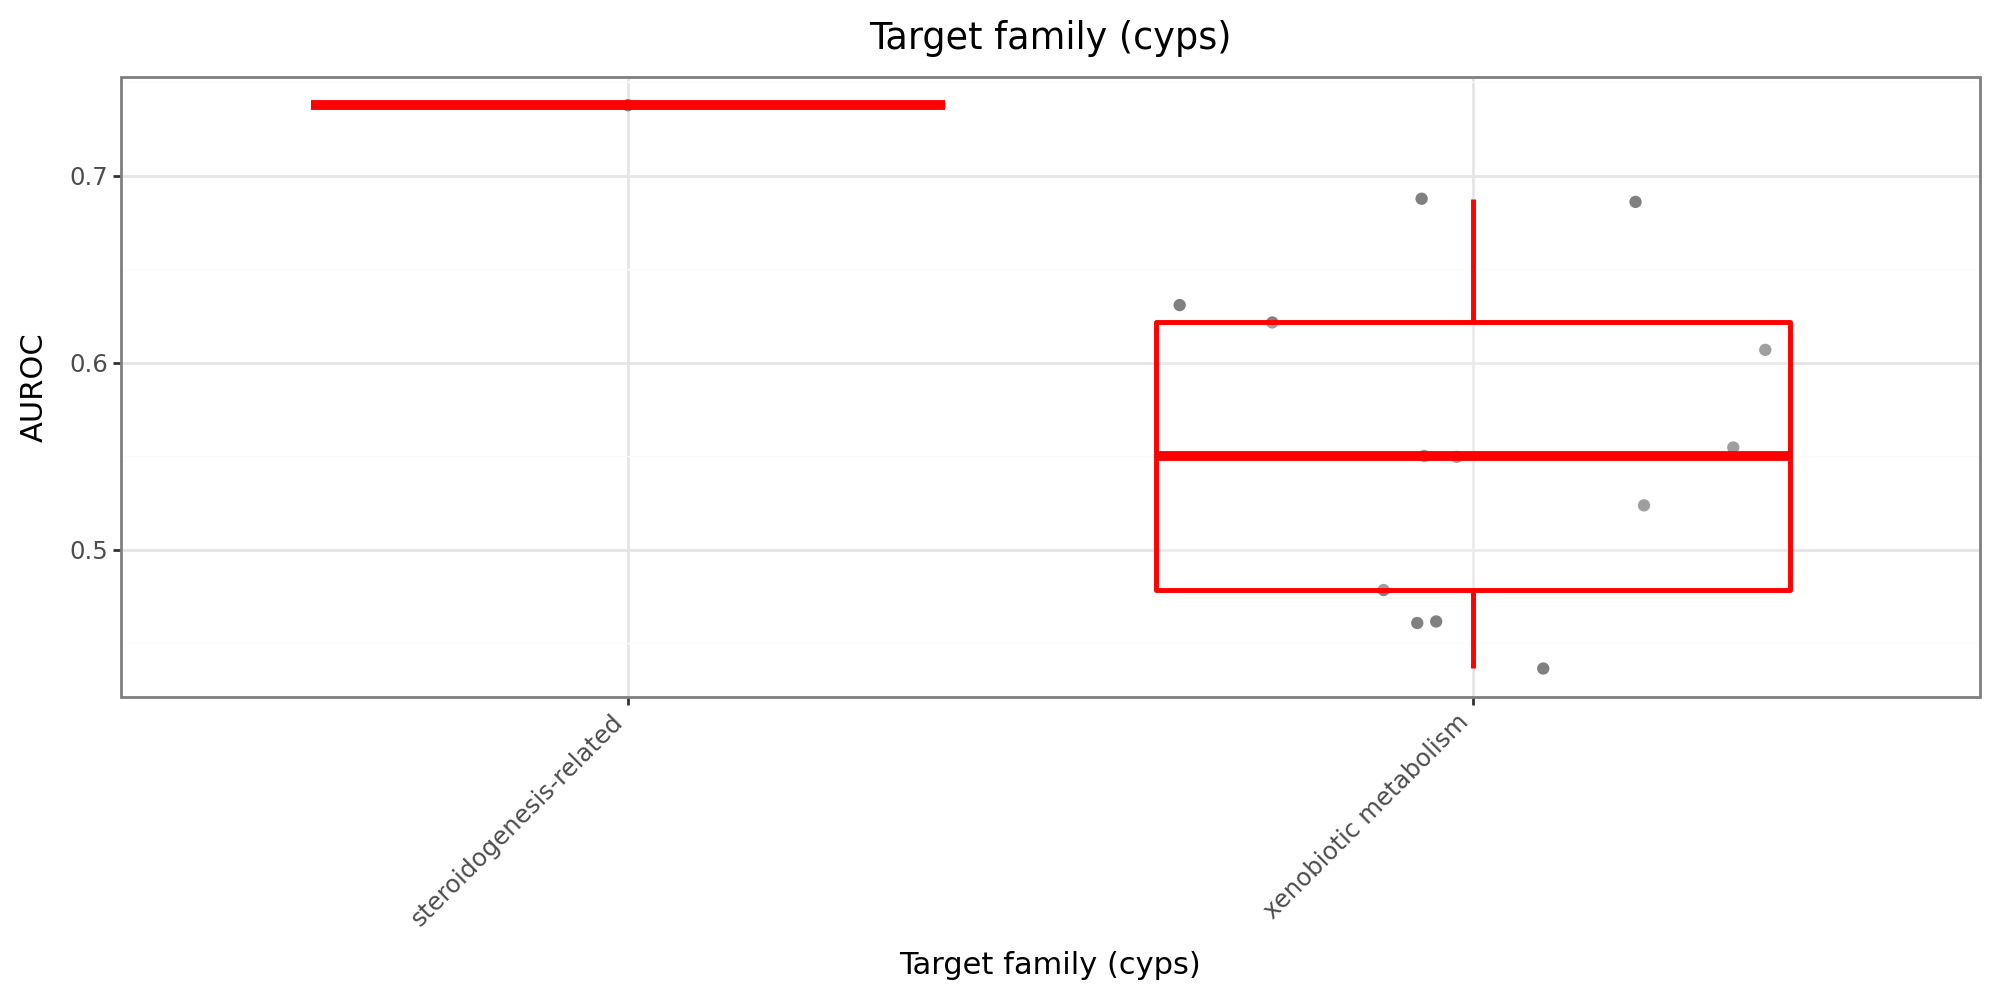

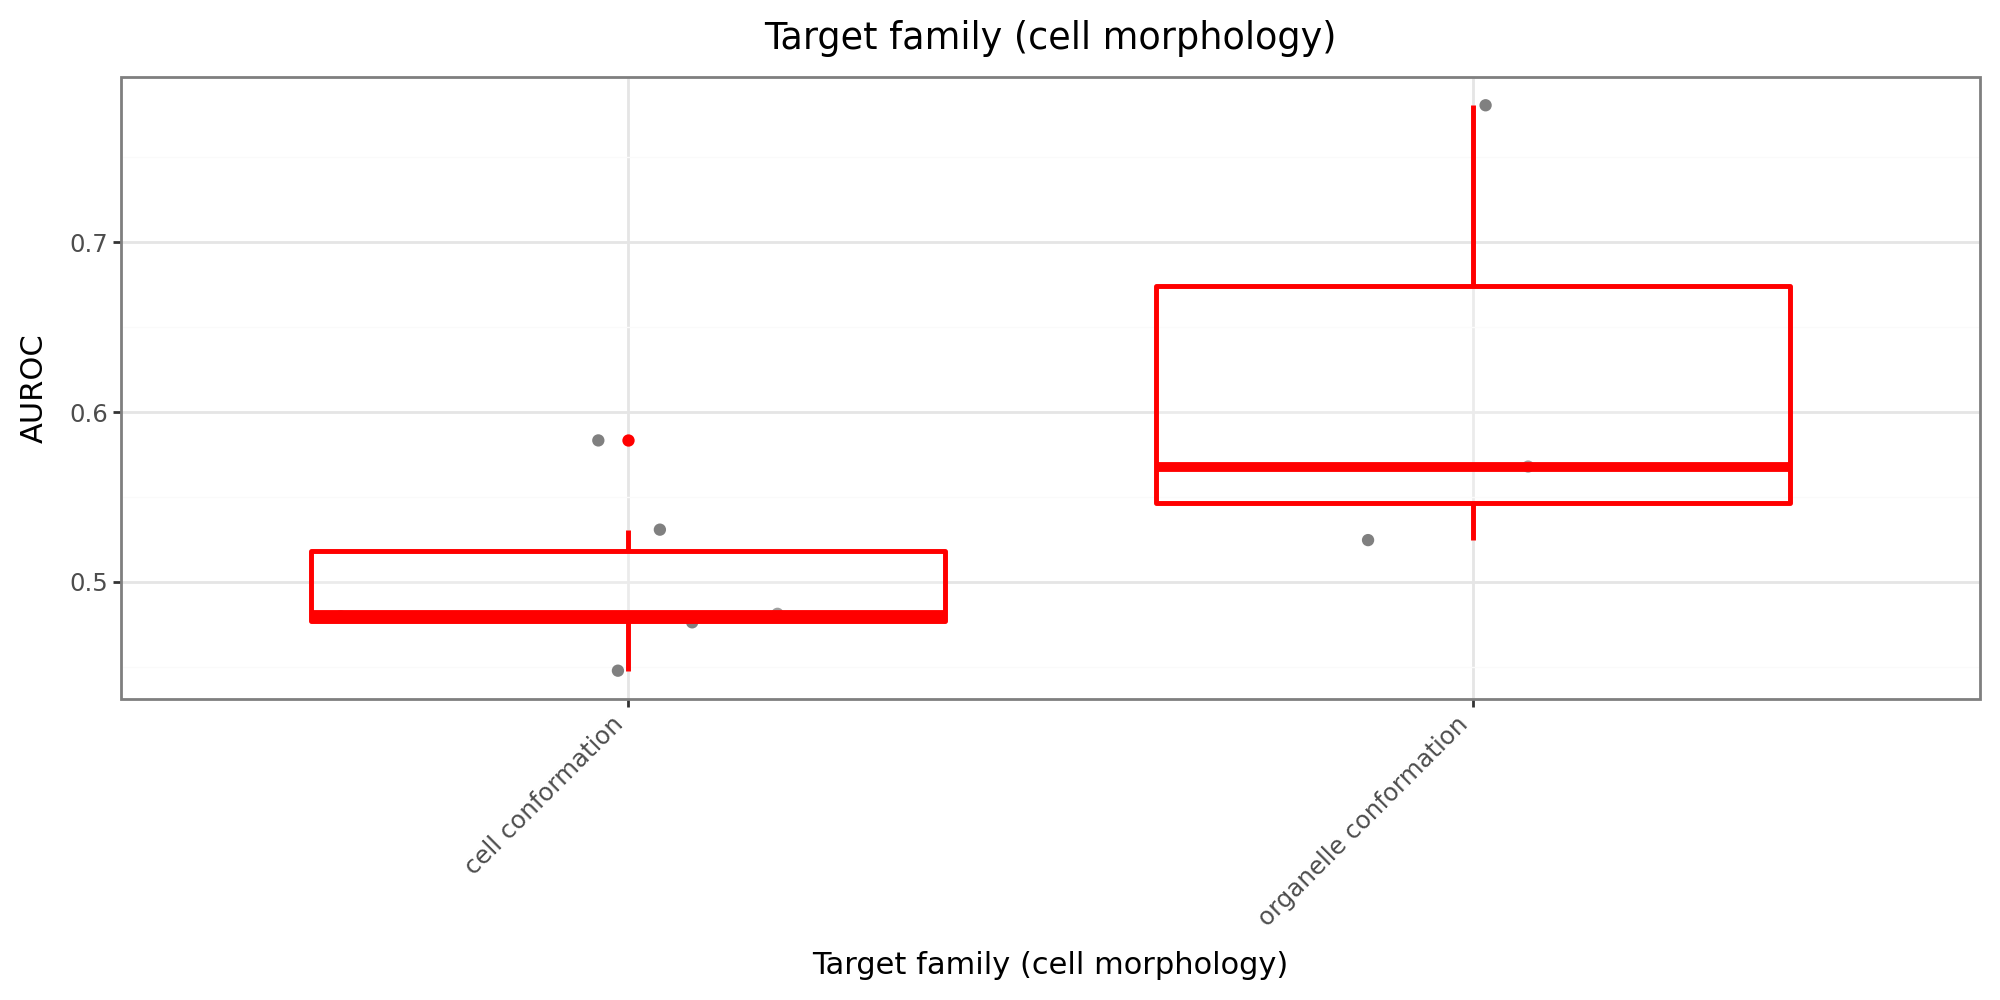

In [11]:
family_df = tissue_df.filter(
    pl.col("intended_target_family").is_in([
        "nuclear receptor",
        "dna binding",
        "cytokine",
        "cyp",
        "cell morphology"
    ])
)

plot = (
    ggplot(family_df, aes(x='intended_target_family', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family', x='Target family', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(family_df.filter(pl.col("intended_target_family") == "nuclear receptor"), aes(x='intended_target_family_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family (nuclear receptors)', x='Target family (nuclear receptors)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(family_df.filter(pl.col("intended_target_family") == "dna binding"), aes(x='intended_target_family_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family (dna binding)', x='Target family (dna binding)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(family_df.filter(pl.col("intended_target_family") == "cytokine"), aes(x='intended_target_family_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family (cytokines)', x='Target family (cytokines)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(family_df.filter(pl.col("intended_target_family") == "cyp"), aes(x='intended_target_family_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family (cyps)', x='Target family (cyps)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()

plot = (
    ggplot(family_df.filter(pl.col("intended_target_family") == "cell morphology"), aes(x='intended_target_family_sub', y='AUROC')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1)
    + labs(title='Target family (cell morphology)', x='Target family (cell morphology)', y='AUROC') 
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1)
    )
)
plot.show()
